# EDA

## Importing modules

And configuting settings

In [4]:
from warnings import filterwarnings
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import pandas_profiling as pp
import seaborn as sns
import sweetviz as sv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, Pool
import xgboost as xgb

import category_encoders as ce

from lib.data_viz_functions import *
from lib.model_related import *

In [2]:
filterwarnings("ignore")
sns.set()

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

%matplotlib inline

In [3]:
train = pd.read_pickle("data/2022-04-06_train_preprocessed.pkl.zip", compression="zip")
test = pd.read_pickle("data/2022-04-06_test_preprocessed.pkl.zip", compression="zip")

## Feature description

- **body_type** - Type of vehicle body (седан, купе, хэтчбек...)  
- **brand** - Manufacture name (bmw, audi...)  
- **color** - Main car's body color  
- **description** - Seller's car description  
- **engine_displacement** - Volume of car's engine (nan if electro)  
- **engine_power** - Engine power in horse powers  
- **fuel_type** - Fuel type (diesel, gasoline, electro...)  
- **km_age** - Vehicle mileage  
- **model_year** - Year when model production was started  
- **number_of_doors** - Number of doors  
- **production_year** - Production year of this car  
- **vehicle_transmission** - Transmission type (auto, robot, mech...)  
- **vendor** - Origin country of brand (EUROPIAN, CHINEESE...)  
- **oweners** - Count of oweners of car  
- **owenership_duration** - Owenership duration  
- **ptc** - Vehicle Registration Certificate (YES, NO, DUP)  
- **drive** - Car drive (4WD, FRONT, REAR)  
- **wheel** - Wheel position in car (RIGHT, LEFT)  
- **price** - Our target column - Car Price  

### Dicts and Lists block

In [4]:
valid_columns_dict = {
    "bodyType": "body_type",
    "engineDisplacement": "engine_displacement",
    "enginePower": "engine_power",
    "fuelType": "fuel_type",
    "mileage": "km_age",
    "modelDate": "model_year",
    "numberOfDoors": "number_of_doors",
    "productionDate": "production_year",
    "vehicleTransmission": "vehicle_transmission",
    "Владельцы": "owners",
    "Владение": "ownership_duration",
    "ПТС": "ptc",
    "Привод": "drive",
    "Руль": "wheel",
}

### Functions

In [1]:
def fillna_owners(s):
    '''
    Filling NAs in owners columns.
    Logic - if car age less then 1 year (365 days) then it new car and have 1 owner
    If car age from 1 year to 2 years - then it can has 2 owbers. And more then 2 years - 3 and above owners
    '''
    if not pd.isna(s[0]):
        return s[0]
    else:
        if s[1] < 365:
            return 1
        elif 365 <= s[1] < 730:
            return 2
        else:
            return 3
        

def get_nans_in_percents(df):
    '''
    Display NANs is percents
    '''
    nans = df.isna().sum() / df.shape[0] * 100
    return nans[nans > 0]


def plot_nans_heatmap(train, test):
    '''
    Plotting NANs heatmap of all DF
    '''
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    sns.heatmap(train.isna(), cmap="YlGnBu", ax=ax[0], cbar=False).set_title(
        "Heatmap for train dataframe"
    )
    sns.heatmap(test.isna(), cmap="YlGnBu", ax=ax[1], cbar=False).set_title(
        "Heatmap for test dataframe"
    )
    plt.show()

## preprocessing and feature engeneering function

In [5]:
def preprocesing(in_df) -> pd.DataFrame:
    '''
    Main func that gets DF, makes all treatment and returns DF ready for modelling
    '''    
    df = in_df.copy()

    enc_list = [
        "body_type",
        "brand",
        "color",
        "fuel_type",
        "vehicle_transmission",
        "vendor",
        "drive",
        "wheel",
        "ptc",
        "age_cat",
    ]

    # ohenc = OneHotEncoder()
    
    # Filling NAs for engine_displacement column.
    electro_mask = (df.engine_displacement.isna()) & (df.fuel_type == "электро")
    df.loc[electro_mask, "engine_displacement"] = 0

    # Changing Parsed_Date from string to DateType
    df["parsed_date"] = pd.to_datetime(df["parsed_date"])
    df["production_year"] = pd.to_datetime(
        df["production_year"].astype(int).astype(str)
    )
    
    # Constructing new feature - Car Age (finally in years)
    df["diff_data"] = (df["parsed_date"] - df["production_year"]).astype(
        "timedelta64[D]"
    )
    df["diff_data_years"] = df["diff_data"] / 365
    
    # New feature - Car age into categorical
    age_mask1 = df["diff_data_years"] >= 60
    age_mask2 = df["diff_data_years"].between(20, 60, inclusive="left")
    age_mask3 = df["diff_data_years"].between(10, 20, inclusive="left")
    age_mask4 = df["diff_data_years"].between(5, 10, inclusive="left")
    age_mask5 = df["diff_data_years"].between(3, 5, inclusive="left")
    age_mask6 = df["diff_data_years"] < 3

    df.loc[age_mask1, "age_cat"] = "retro"
    df.loc[age_mask2, "age_cat"] = "old"
    df.loc[age_mask3, "age_cat"] = "med"
    df.loc[age_mask4, "age_cat"] = "not_bad"
    df.loc[age_mask5, "age_cat"] = "may_be_on_garant"
    df.loc[age_mask6, "age_cat"] = "almost_new"
    
    # 3 new features from car age
    df["retro"] = (df["diff_data_years"] >= 60).astype(int)
    df["most_wanted"] = (df["diff_data_years"] <= 3).astype(int)
    df["good_cond"] = (df["diff_data_years"].between(3, 5, inclusive="right")).astype(int)
    
    
    # Categories from Engine Volume
    # vol_mask1 = df['engine_displacement'] <= 1.1
    # vol_mask2 = df['engine_displacement'].between(1.1, 1.8, inclusive='right')
    # vol_mask3 = df['engine_displacement'].between(1.8, 3.5, inclusive='right')
    # vol_mask4 = df['engine_displacement'] > 3.5

    # df.loc[vol_mask1, 'vol_cat'] = 'micro'
    # df.loc[vol_mask2, 'vol_cat'] = 'mini'
    # df.loc[vol_mask3, 'vol_cat'] = 'medium'
    # df.loc[vol_mask4, 'vol_cat'] = 'fuel_eater'
    
    # New feature - mileage by year
    df["km_per_year"] = df["km_age"] / df["diff_data_years"]

    df["production_year"] = df["production_year"].dt.year
    
    # Filling NANs in owners column
    df["owners"] = df[["owners", "diff_data"]].apply(fillna_owners, axis=1)
    
    # Filling NANs in description to 'No description'
    mask_descr = df["description"].isna()
    df.loc[mask_descr, "description"] = "No description"
    df["desc_count"] = df["description"].str.split().str.len()
    
    # Converting Number of doors and Owners to INT
    df["number_of_doors"] = df["number_of_doors"].astype("int")
    df["owners"] = df["owners"].astype("int")
    
    # Trying categorize description to Dealer-Nodealer by key-words
    dealer_words = "официальный|автосалон|дилер|выкуп|взаимозачет|тест драйв|тест|драйв|автокредит|менеджер|клиент|кредит|страхование|автостраховка|страховка"
    df["dealer"] = df["description"].str.contains(dealer_words).astype(int)
    
    # Block of poly-features - not useful
    
    # top_body = df['body_type'].value_counts()[:2].index.tolist()
    # df['top_body'] = df['body_type'].isin(top_body).astype(int)

    # rare_body = df['body_type'].value_counts()[-4:].index.tolist()
    # df['rare_body'] = df['body_type'].isin(rare_body).astype(int)

    # top_color = df['color'].value_counts()[:4].index.tolist()
    # df['top_color'] = df['color'].isin(top_color).astype(int)

    # rare_color = df['color'].value_counts()[-4:].index.tolist()
    # df['rare_color'] = df['color'].isin(rare_color).astype(int)

    # Couple of attempts encode features. The best were LabelEncoding for model_name and Dummies for others
    
    # cenc = ce.BackwardDifferenceEncoder(cols=enc_list)
    # df = df.join(cenc.fit_transform(df[enc_list], verbose=1))
    # df = df.join(pd.get_dummies(df[enc_list], columns=enc_list))
    # df['model_name'] =  df['model_name'].astype('category').cat.codes
    # df = df.join(pd.DataFrame(ohenc.fit_transform(df[['vol_cat']]).toarray()).astype(int))

    # df.drop(enc_list, axis=1, inplace=True)

    return df

### Renaming columns to english and snake-type (from dict)

In [7]:
train.rename(columns=valid_columns_dict, inplace=True)
test.rename(columns=valid_columns_dict, inplace=True)

## removing cols

In [9]:
del train["ownership_duration"]
del test["ownership_duration"]

## Grouping cols as categorical and numeric

In [10]:
cat_cols = [
    "body_type",
    "brand",
    "color",
    "fuel_type",
    "number_of_doors",
    "vehicle_transmission",
    "vendor",
    "owners",
    "ptc",
    "drive",
    "wheel",
]
nums_cols = [
    "engine_displacement",
    "engine_power",
    "km_age",
    "model_year",
    "production_year",
    # "ownership_duration",
]

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115367 entries, 0 to 115368
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   body_type             115367 non-null  object 
 1   brand                 115367 non-null  object 
 2   color                 115367 non-null  object 
 3   description           112155 non-null  object 
 4   engine_displacement   115209 non-null  float64
 5   engine_power          115367 non-null  float32
 6   fuel_type             115367 non-null  object 
 7   km_age                115367 non-null  float32
 8   model_year            115367 non-null  float32
 9   model_name            115367 non-null  object 
 10  number_of_doors       115367 non-null  float32
 11  production_year       115367 non-null  float32
 12  vehicle_transmission  115367 non-null  object 
 13  vendor                115367 non-null  object 
 14  owners                104832 non-null  float64
 15  

## Discovering NA

In [12]:
get_nans_in_percents(train)

description            2.784158
engine_displacement    0.136954
owners                 9.131727
ptc                    0.301646
dtype: float64

In [13]:
get_nans_in_percents(test)

engine_displacement    0.158565
ptc                    0.002883
dtype: float64

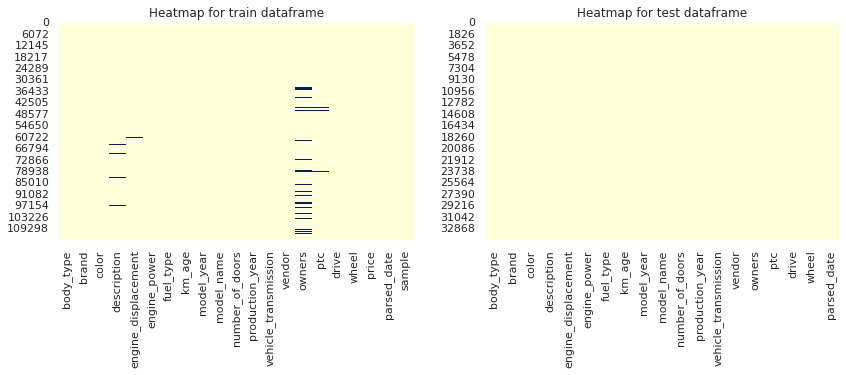

In [14]:
plot_nans_heatmap(train, test)

In [15]:
train.loc[train.km_age.isna()]

,body_type,brand,color,description,engine_displacement,engine_power,fuel_type,km_age,model_year,model_name,number_of_doors,production_year,vehicle_transmission,vendor,owners,ptc,drive,wheel,price,parsed_date,sample


## Numeric variables overview

In [16]:
describe_nums(train[nums_cols + ["price"]])

,unique,n/a count,count,mean,std,min,25%,50%,75%,max
km_age,28798,0,115367.000000,140256.546875,99727.398438,0.000000,69208.000000,133000.000000,196821.500000,1000000.000000
price,10660,0,115367.000000,1373094.201236,1908124.369307,16000.000000,391500.000000,750000.000000,1637000.000000,99000000.000000
engine_power,406,0,115367.000000,176.565292,85.571007,11.000000,117.000000,150.000000,211.000000,800.000000
production_year,81,0,115367.000000,2010.820312,6.889666,1904.000000,2007.000000,2012.000000,2016.000000,2021.000000
model_year,80,0,115367.000000,2008.596069,7.258581,1904.000000,2005.000000,2010.000000,2014.000000,2021.000000
engine_displacement,67,158,115209.000000,2.257130,0.913561,0.700000,1.600000,2.000000,2.500000,8.400000


Unique values count: 67 
Q1: 1.600000023841858
Q3: 2.5
IQR: 0.8999999761581421 
Outliers borders: [0.2500000596046448, 3.849999964237213]


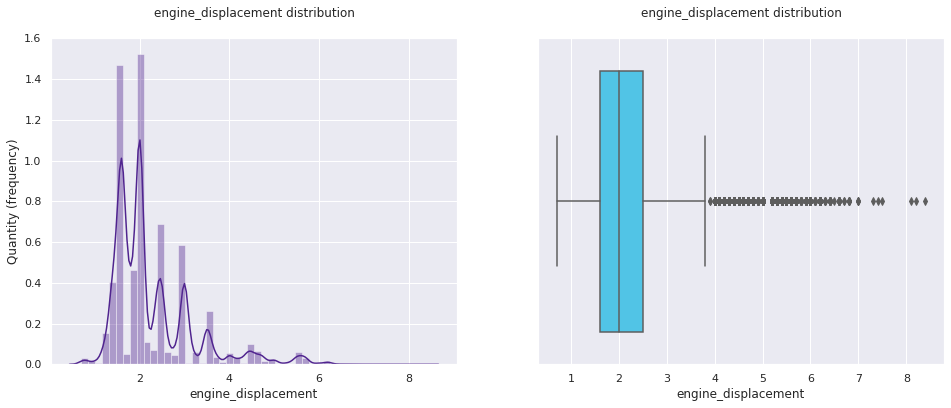

Unique values count: 406 
Q1: 117.0
Q3: 211.0
IQR: 94.0 
Outliers borders: [-24.0, 352.0]


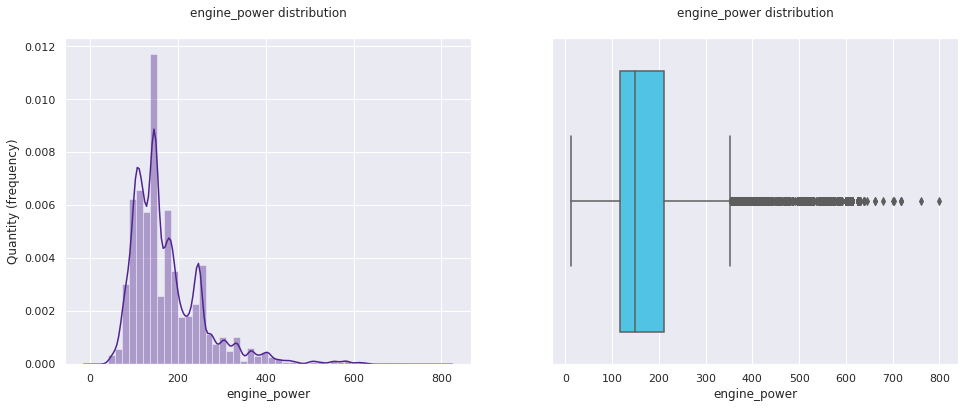

Unique values count: 28798 
Q1: 69208.0
Q3: 196821.5
IQR: 127613.5 
Outliers borders: [-122212.25, 388241.75]


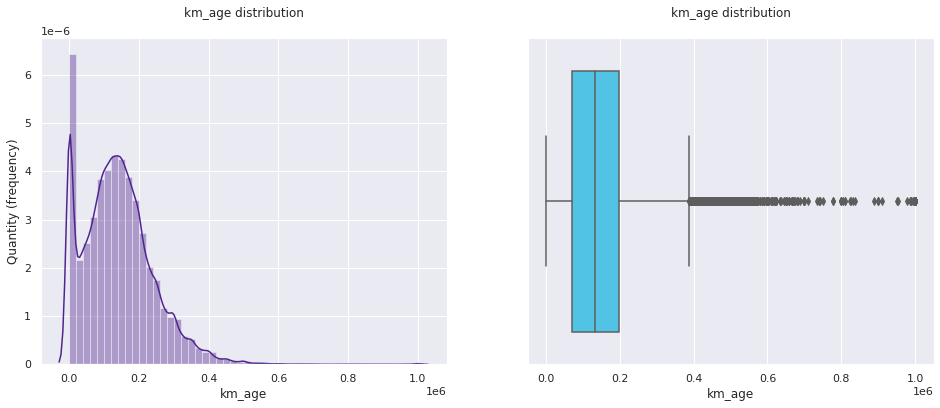

Unique values count: 80 
Q1: 2005.0
Q3: 2014.0
IQR: 9.0 
Outliers borders: [1991.5, 2027.5]


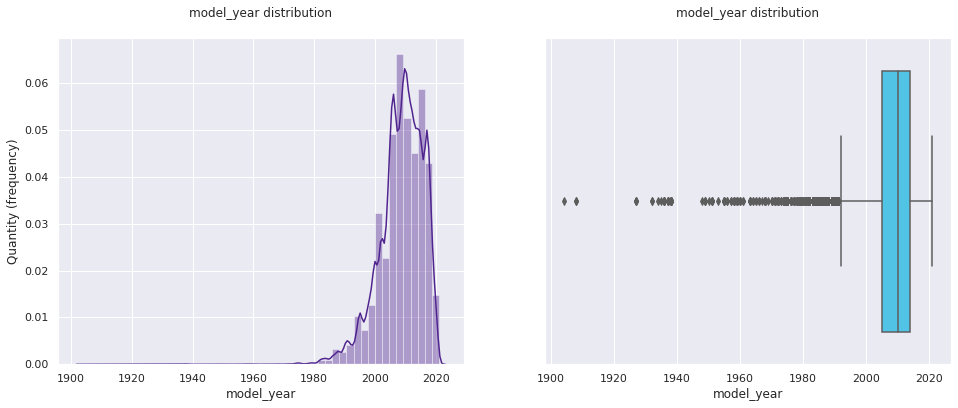

Unique values count: 81 
Q1: 2007.0
Q3: 2016.0
IQR: 9.0 
Outliers borders: [1993.5, 2029.5]


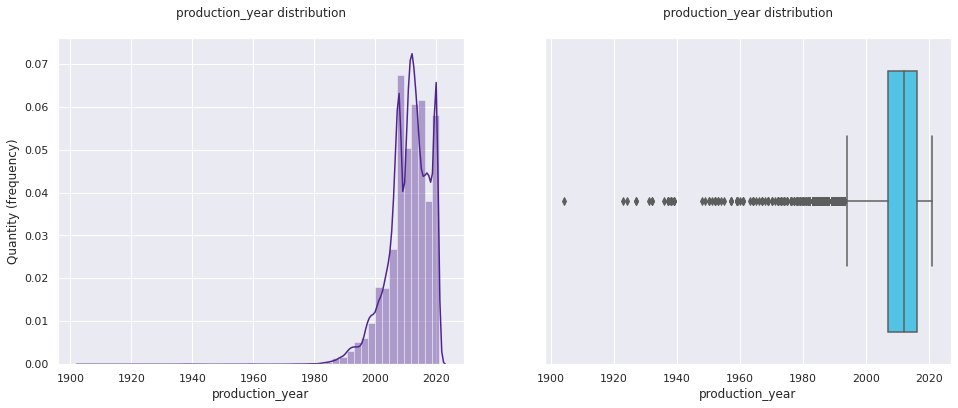

In [17]:
for c in nums_cols:
    show_IQR(train[c])

In [18]:
# for c in nums_cols:
#     show_IQR(test[c])

Unique values count: 35 
Q1: 2.0
Q3: 3.0
IQR: 1.0 
Outliers borders: [0.5, 4.5]


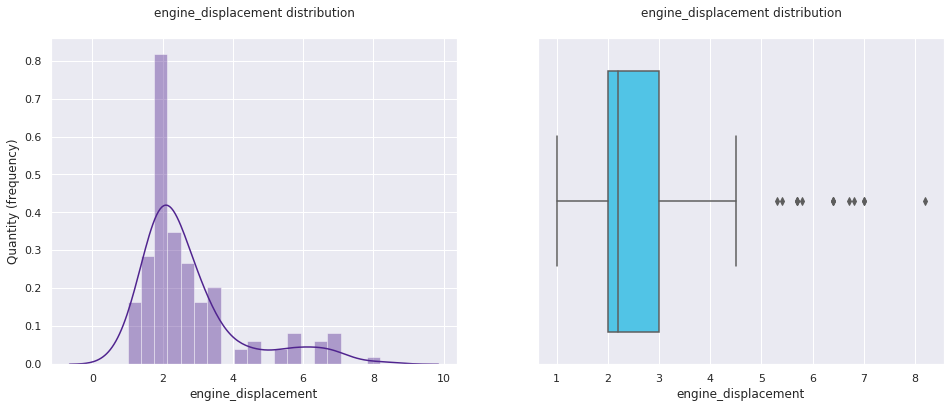

Unique values count: 62 
Q1: 55.0
Q3: 150.0
IQR: 95.0 
Outliers borders: [-87.5, 292.5]


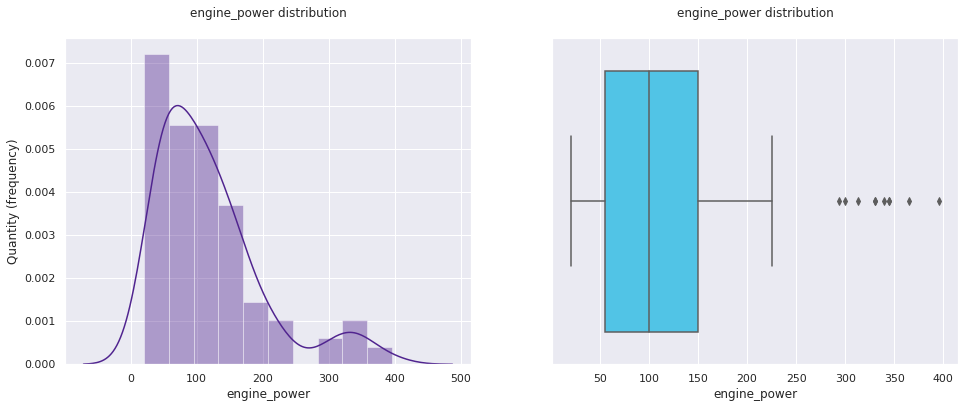

Unique values count: 89 
Q1: 27000.0
Q3: 150000.0
IQR: 123000.0 
Outliers borders: [-157500.0, 334500.0]


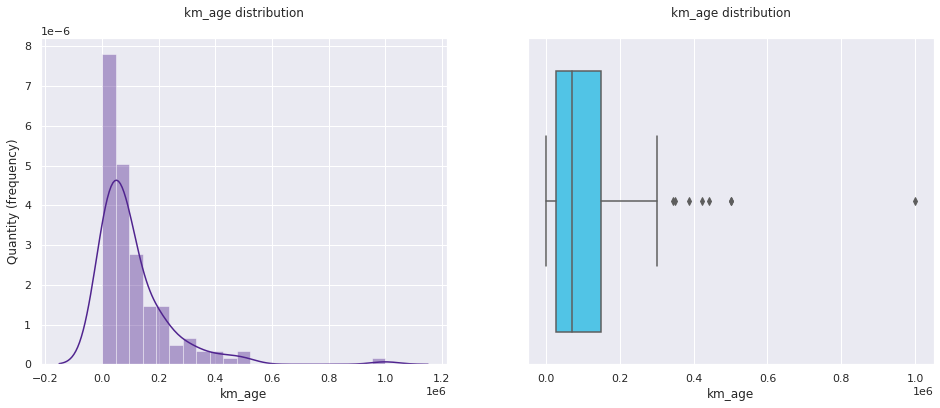

Unique values count: 37 
Q1: 1949.0
Q3: 1972.0
IQR: 23.0 
Outliers borders: [1914.5, 2006.5]


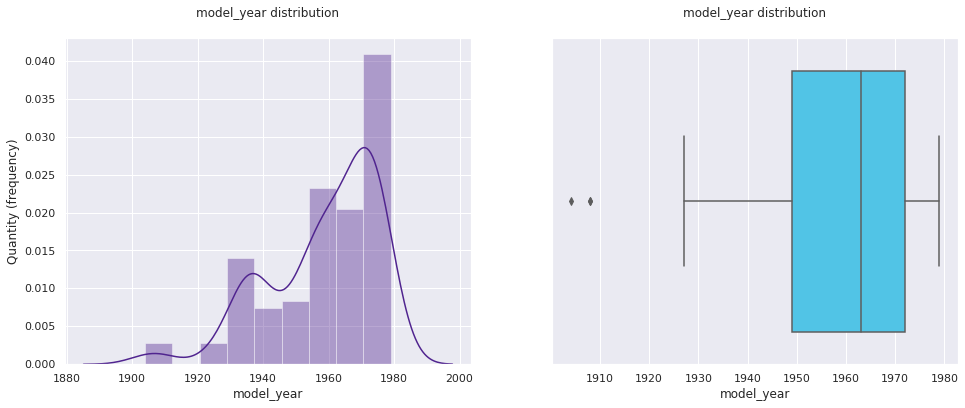

Unique values count: 39 
Q1: 1955.0
Q3: 1976.0
IQR: 21.0 
Outliers borders: [1923.5, 2007.5]


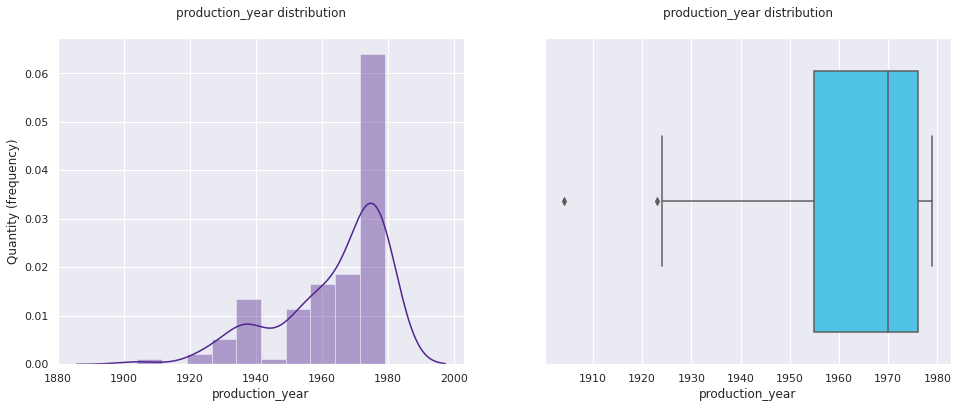

In [19]:
for c in nums_cols:
    show_IQR(train[train["production_year"] < 1980][c])

#### We can see outliers. They seem like real. So to standatrize and to log

## Categorical columns overview

In [20]:
train.describe(include="object").T

,count,unique,top,freq
body_type,115367,16,внедорожник,44065
brand,115367,36,MERCEDES,10080
color,115367,16,чёрный,32686
description,112155,103308,рольф северо запад это первый мегамолл автомоб...,244
fuel_type,115367,5,бензин,96259
model_name,115367,1166,OCTAVIA,2545
vehicle_transmission,115367,4,AUTOMATIC,64367
vendor,115367,5,EUROPEAN,56641
ptc,115019,2,Оригинал,100643
drive,115367,3,передний,58265


In [21]:
train["owners"].astype("object").describe()

count     104832.0
unique         3.0
top            3.0
freq       48461.0
Name: owners, dtype: float64

In [22]:
train[cat_cols].describe(exclude="object").T

,count,mean,std,min,25%,50%,75%,max
number_of_doors,115367.0,4.525939,0.654002,0.0,4.0,5.0,5.0,5.0
owners,104832.0,2.192165,0.833943,1.0,1.0,2.0,3.0,3.0


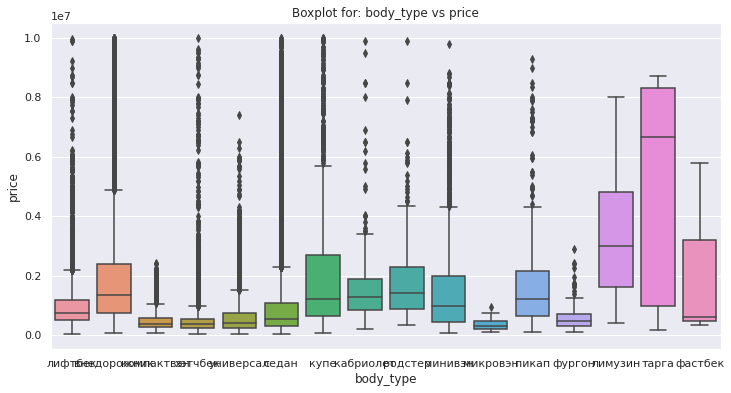

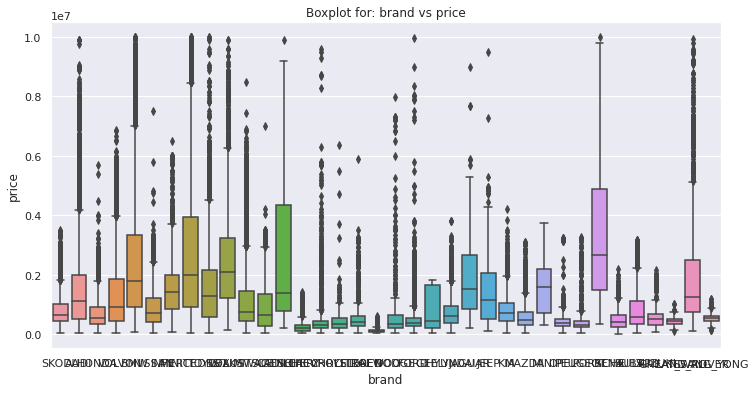

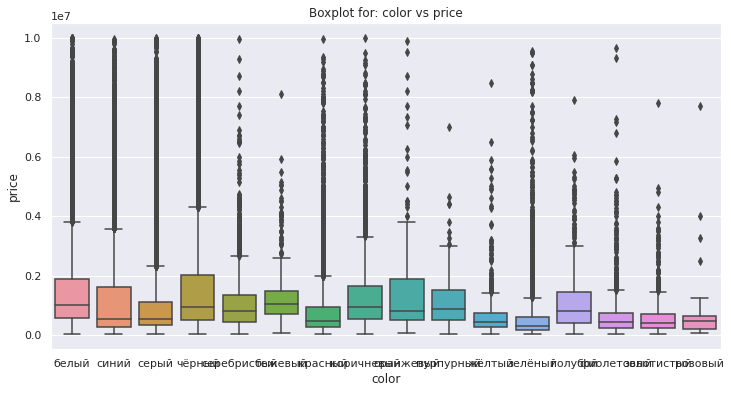

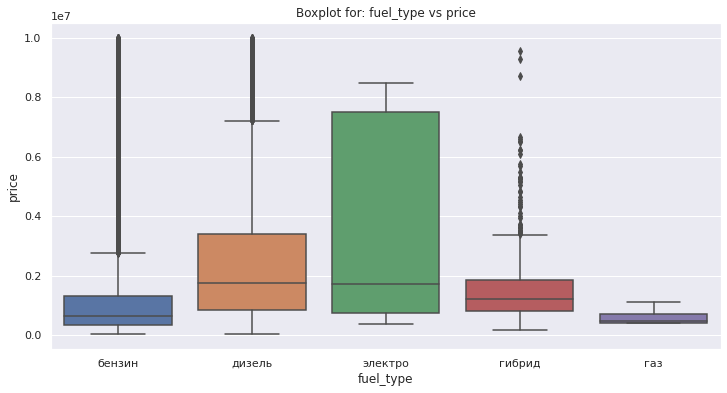

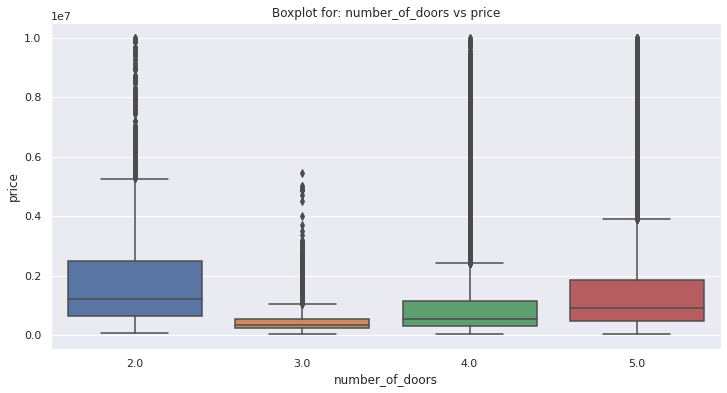

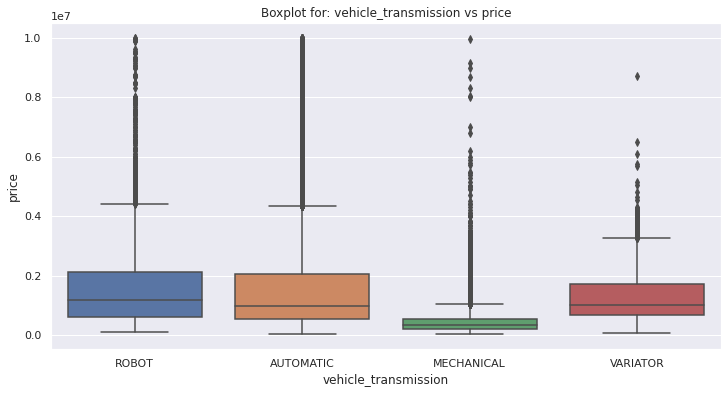

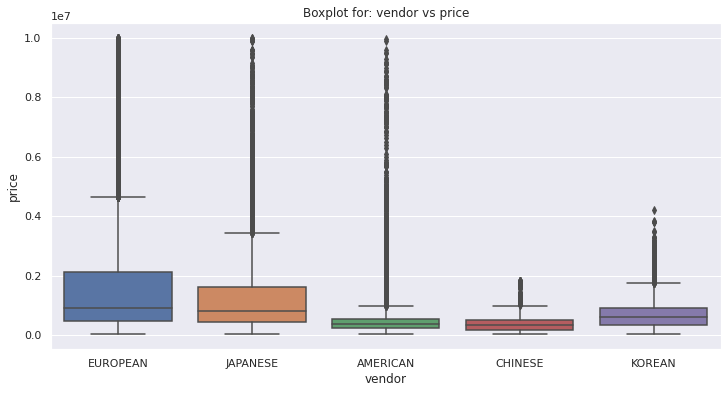

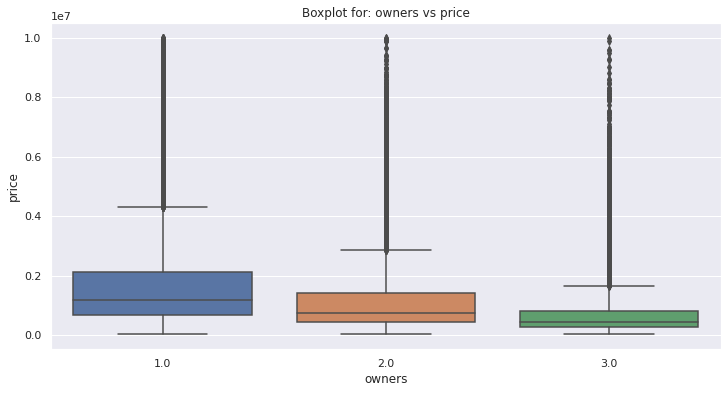

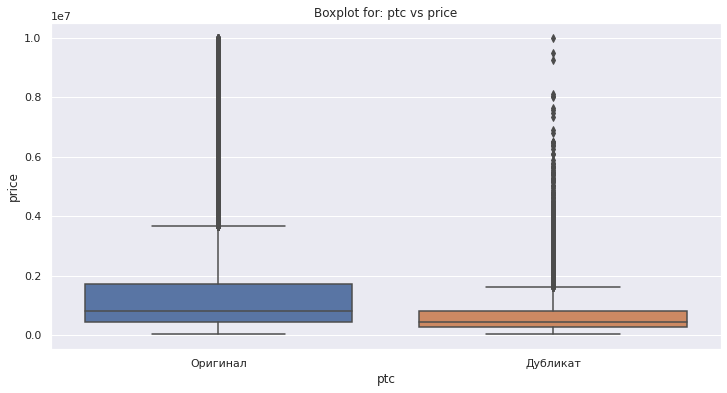

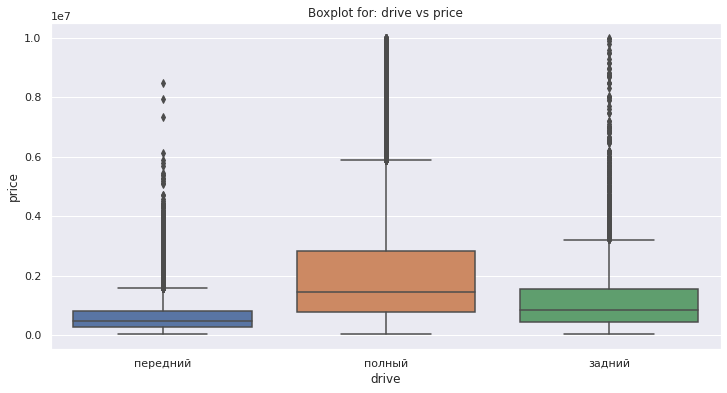

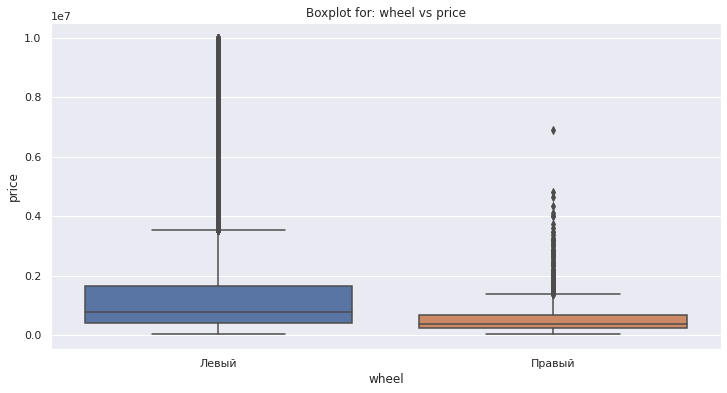

In [23]:
for c in cat_cols:
    show_boxplots(train.query("price < 10_000_000"), c, "price")

## Automated EDA

In [24]:
comp = sv.compare(train, test)

                                             |          | [  0%]   00:00 -> (? left)


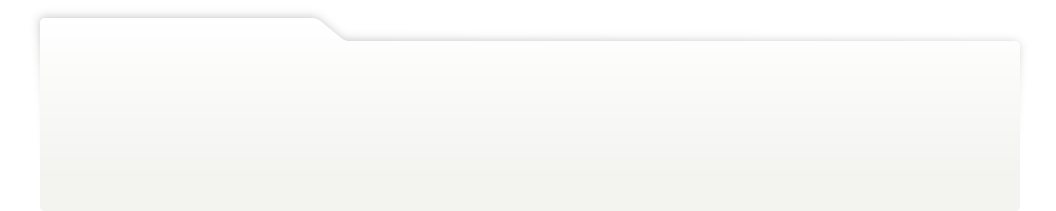
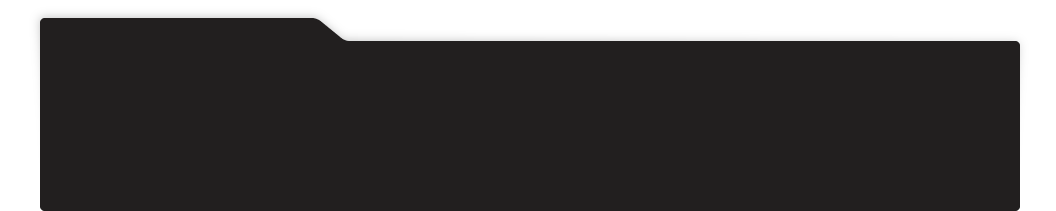
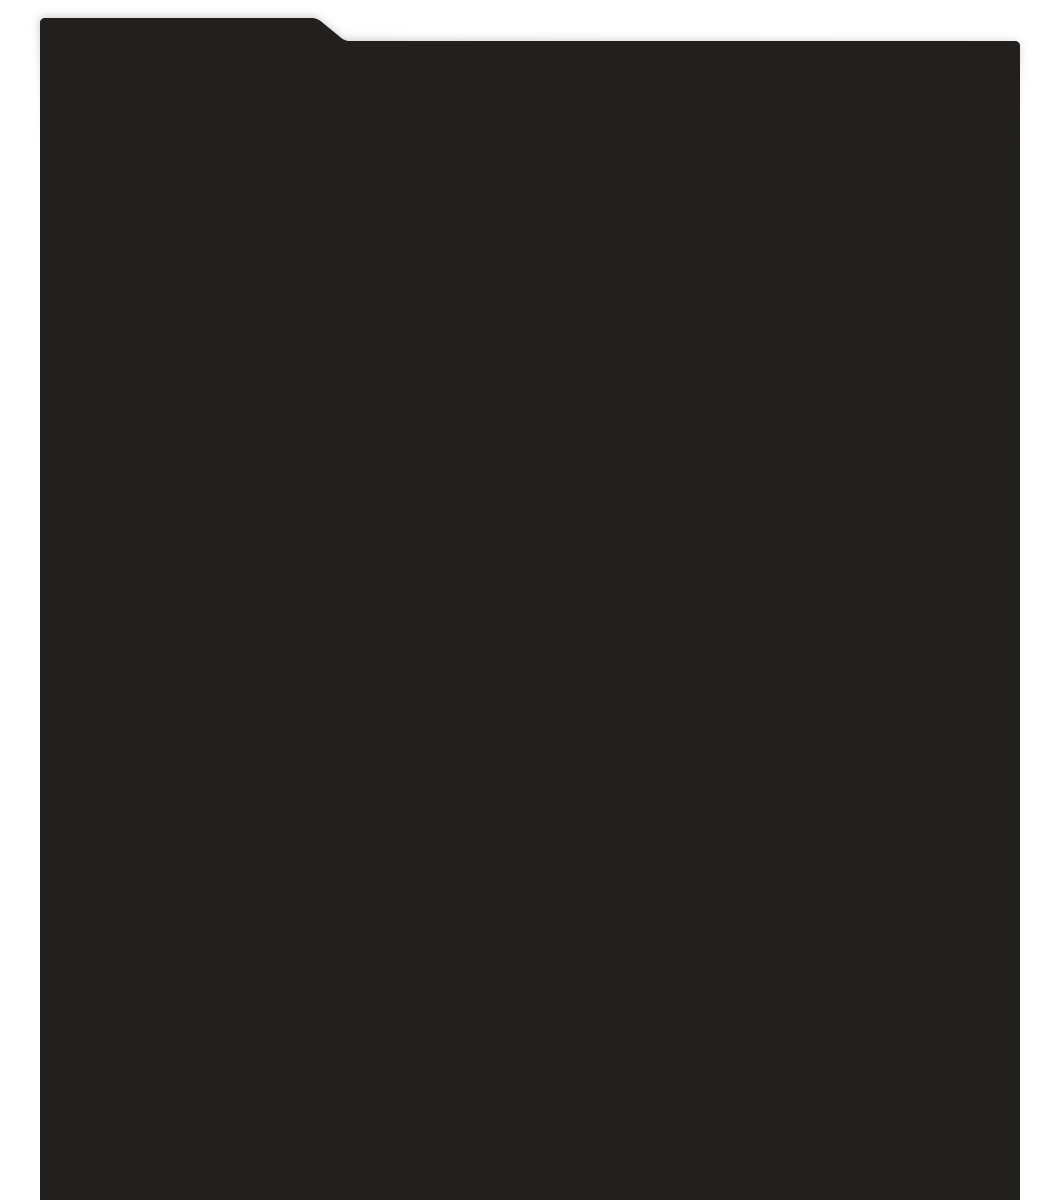
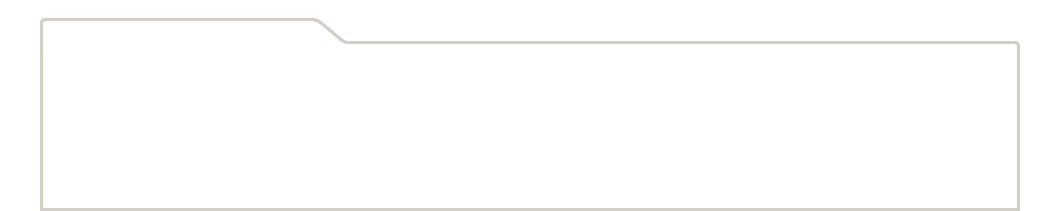
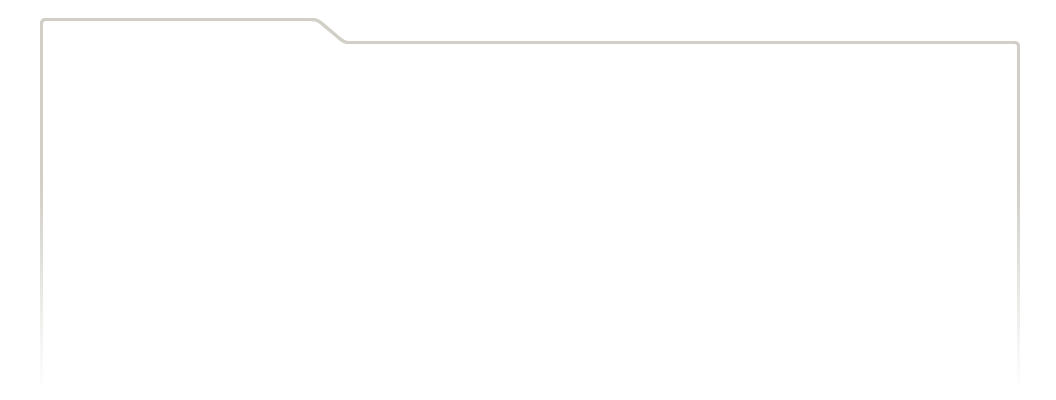
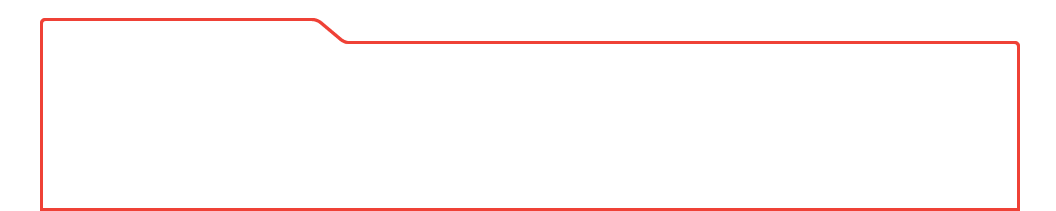
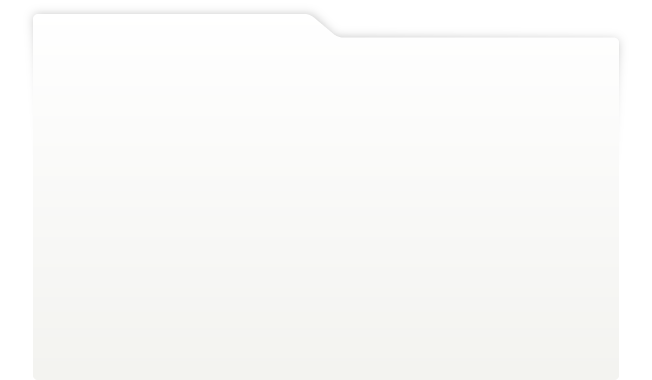
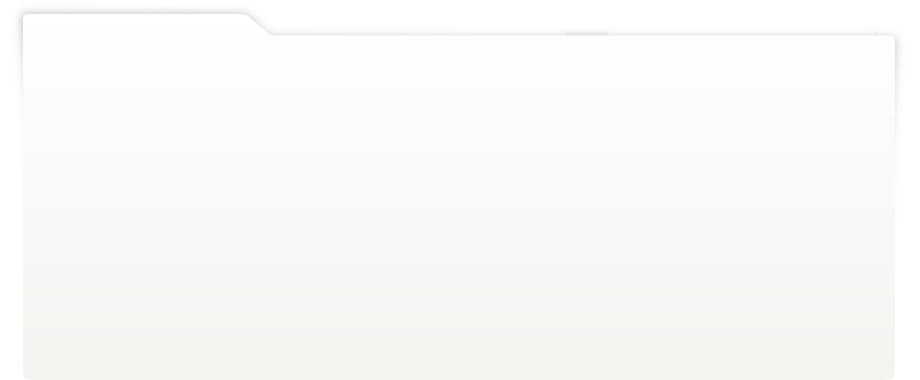
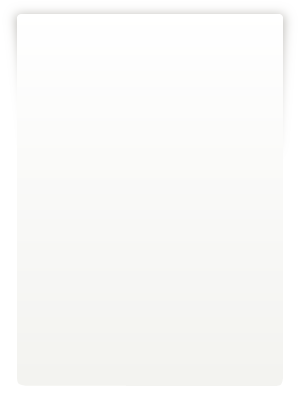
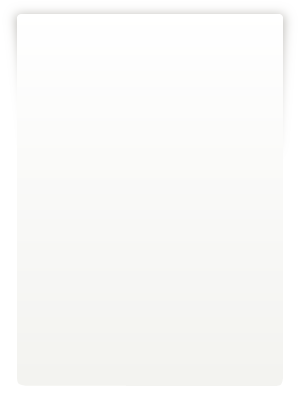
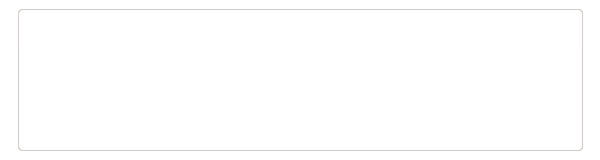
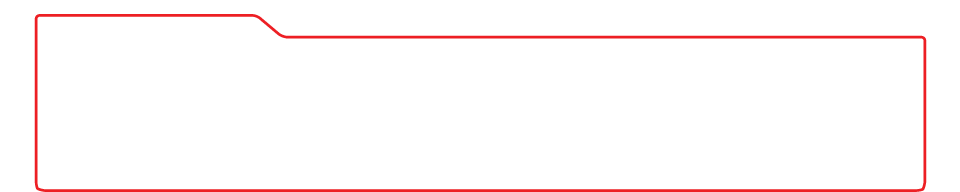
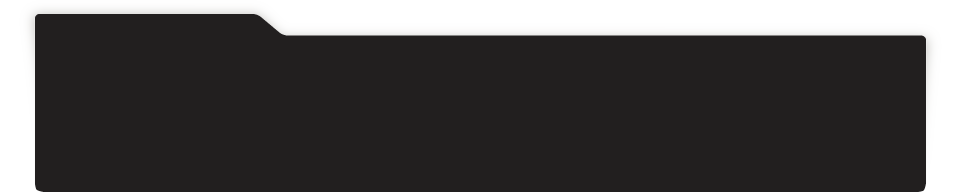
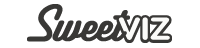
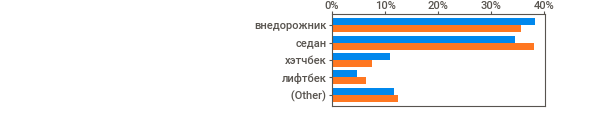
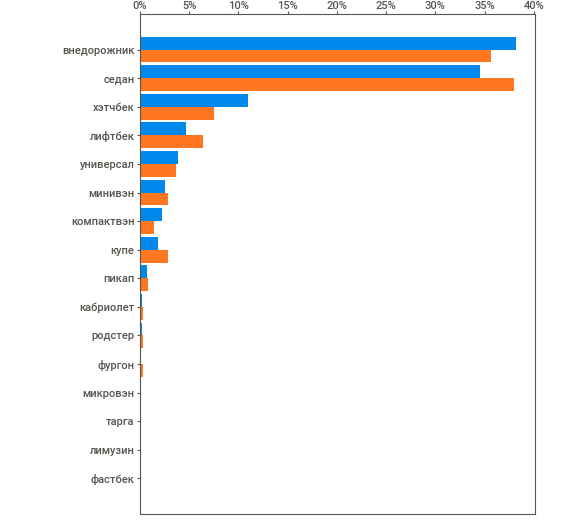
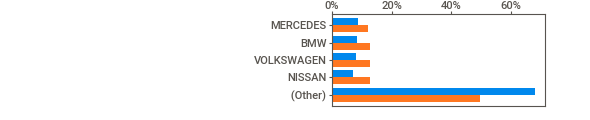
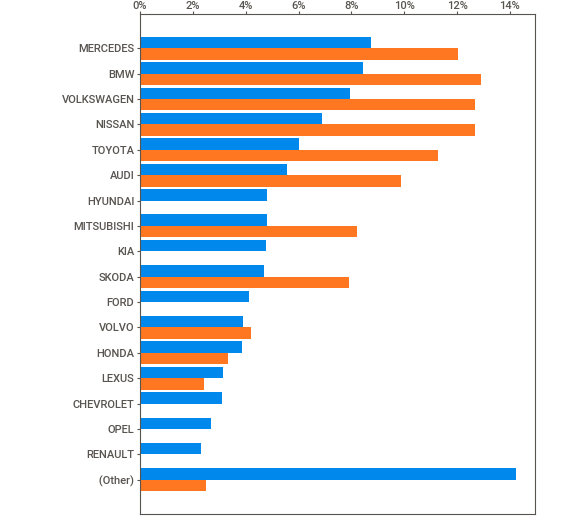
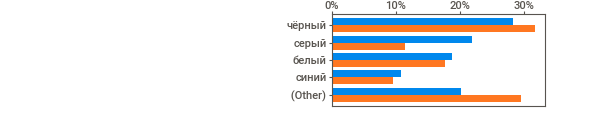
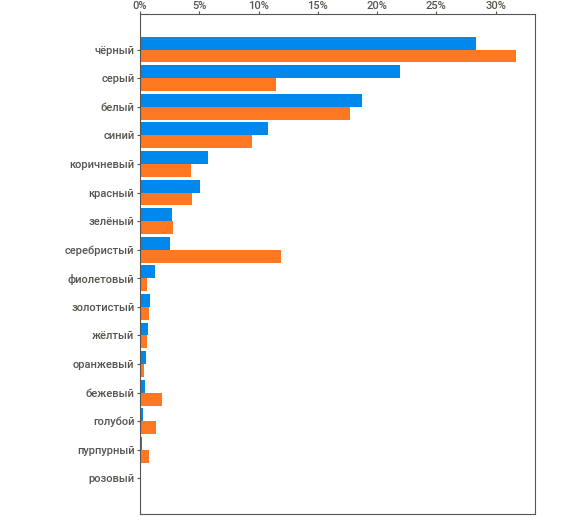
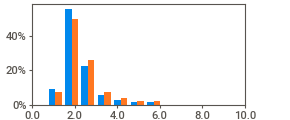
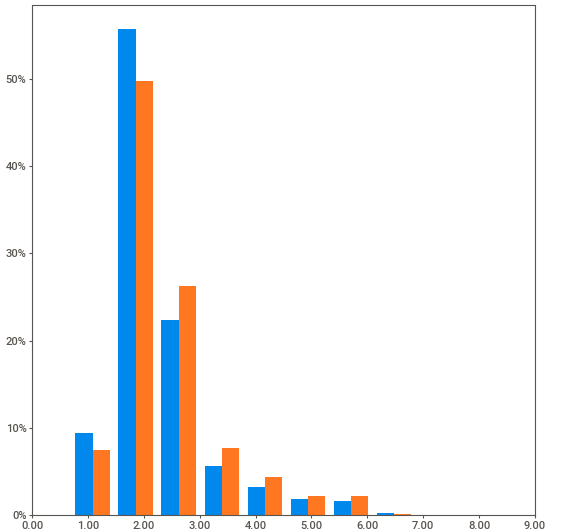
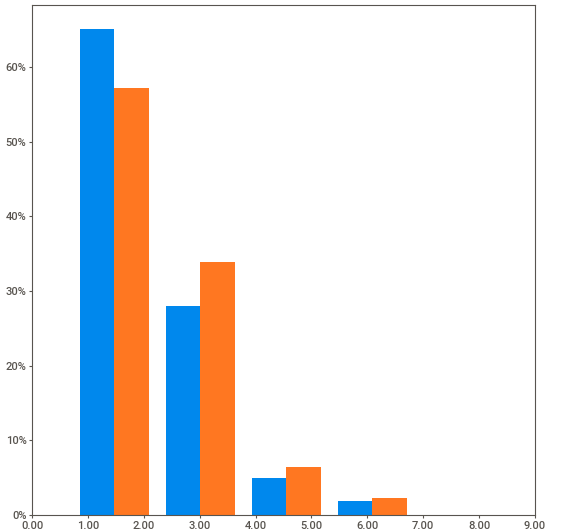
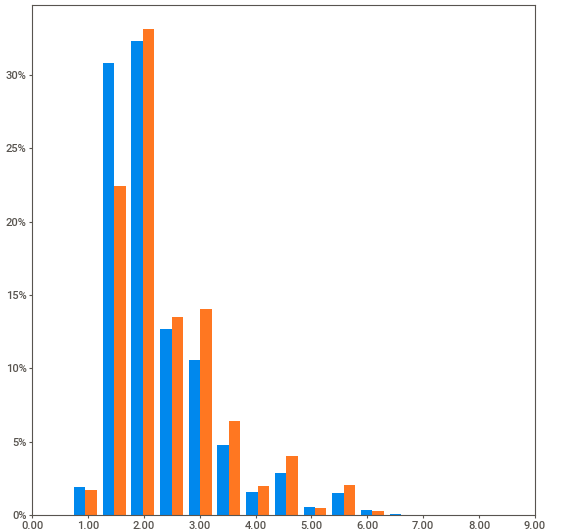
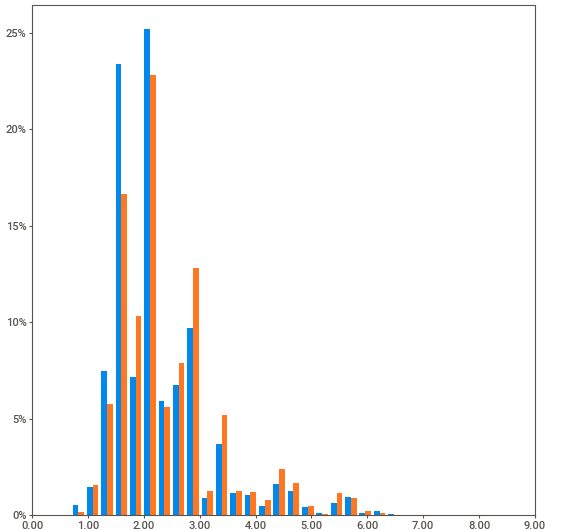
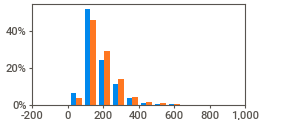
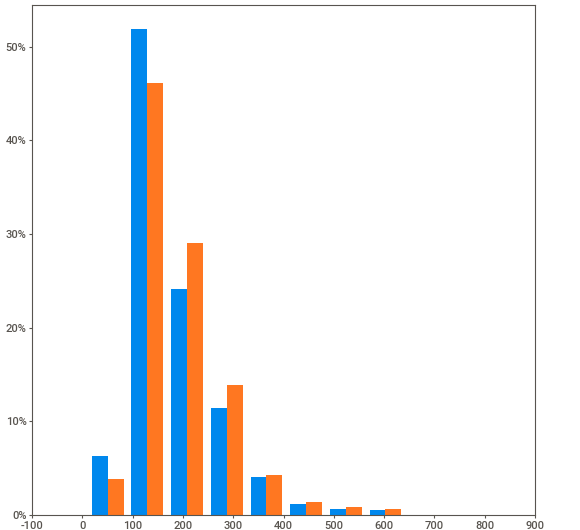
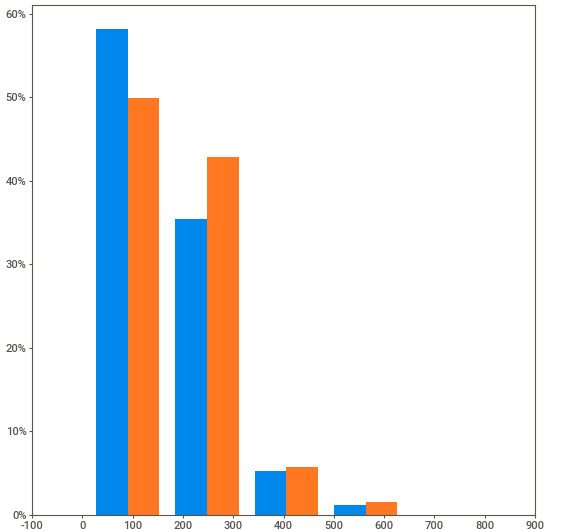
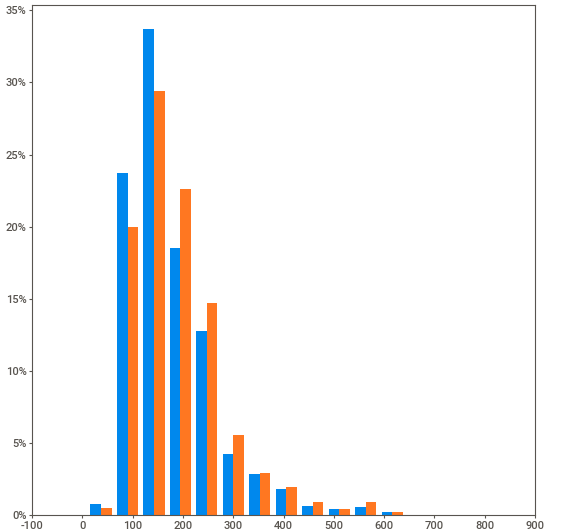
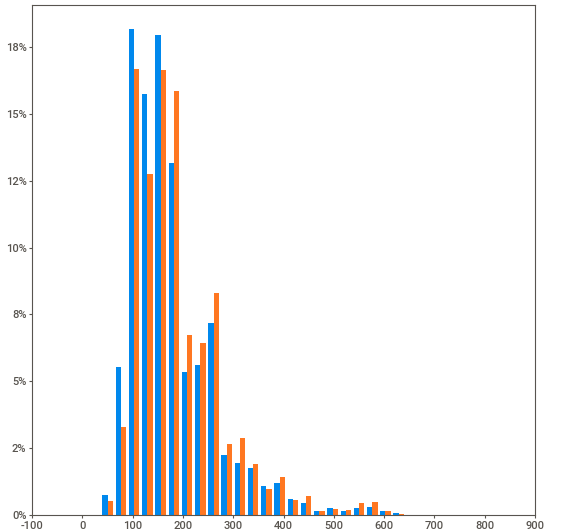
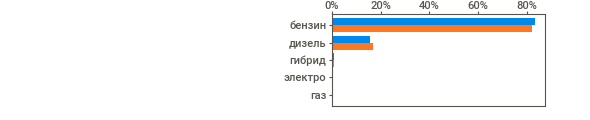
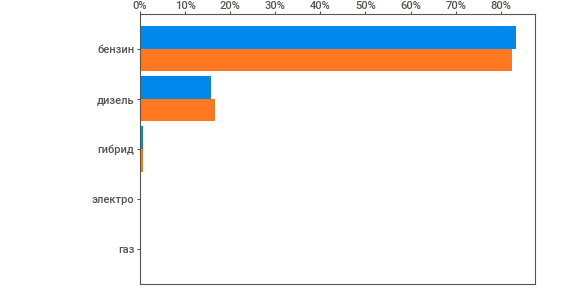
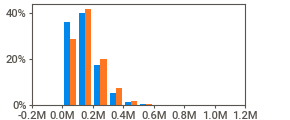
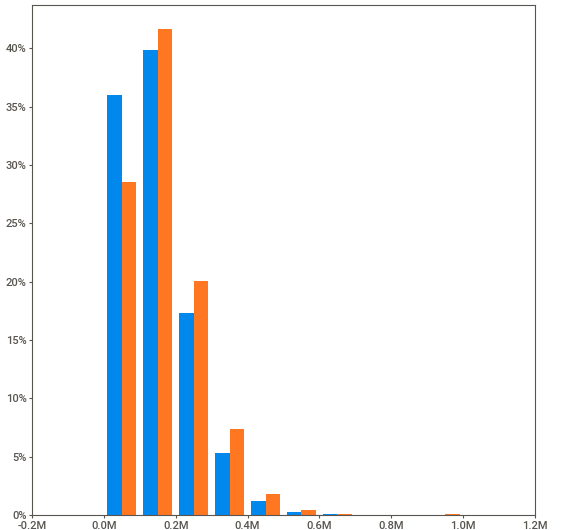
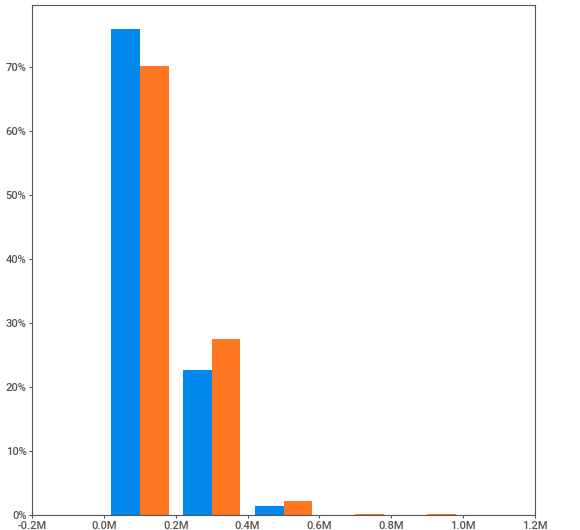
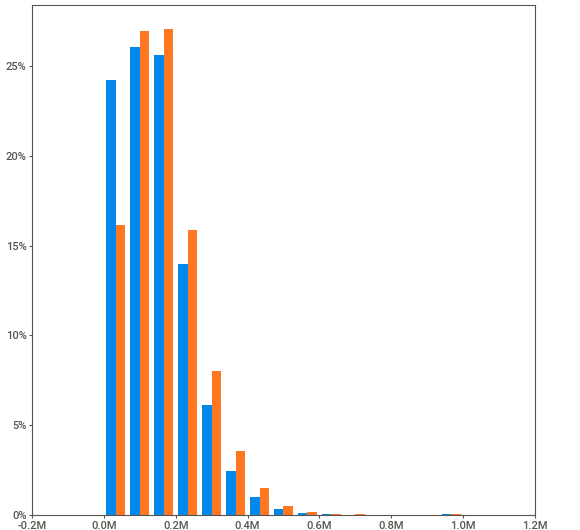
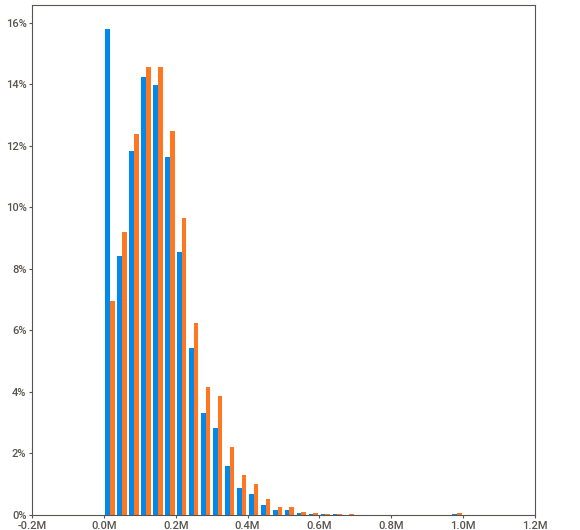
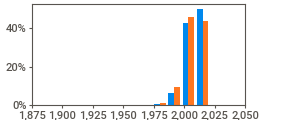
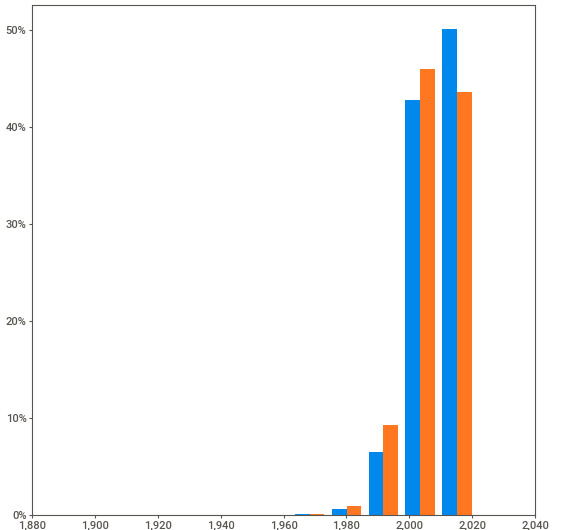
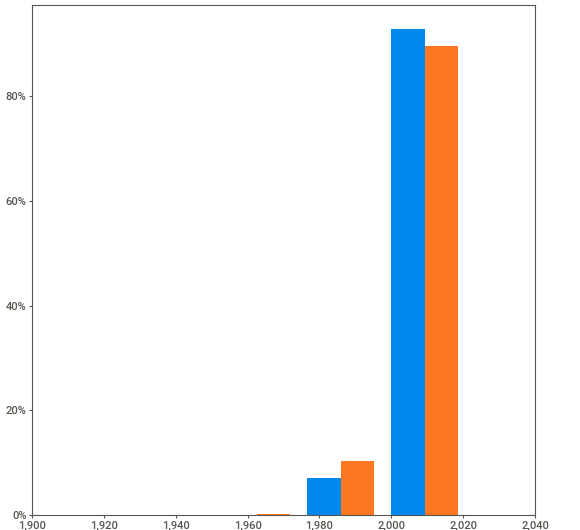
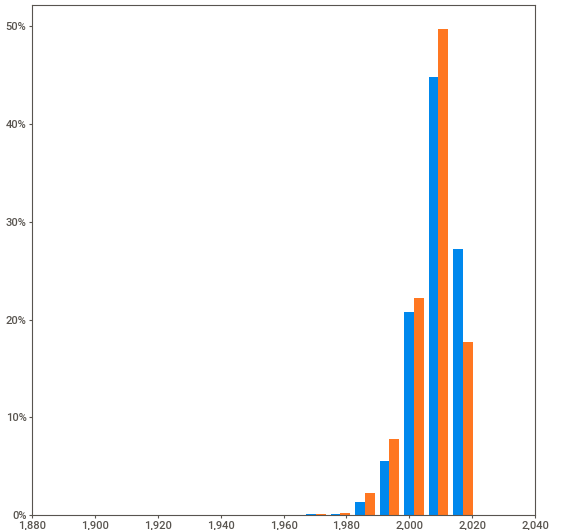
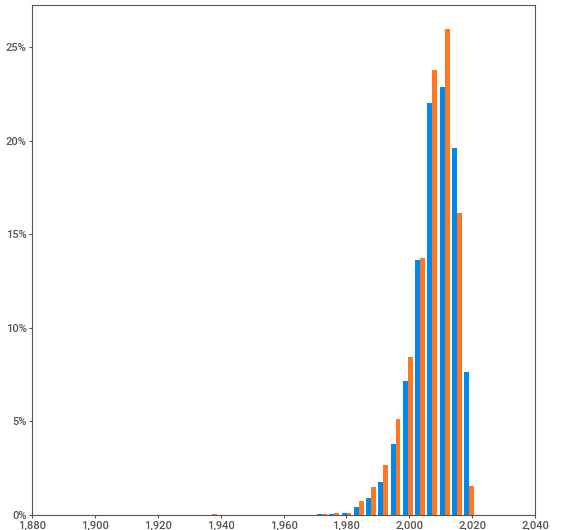
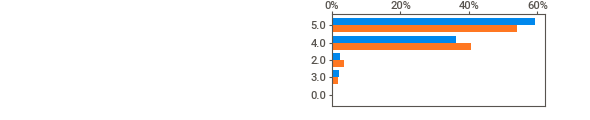
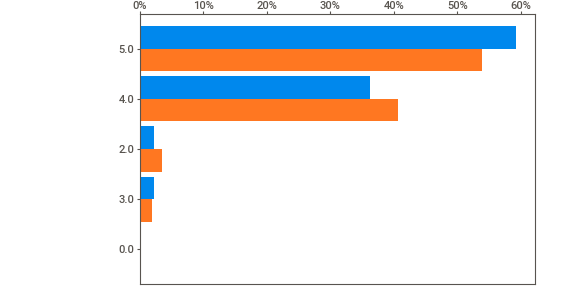
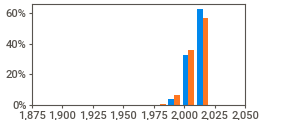
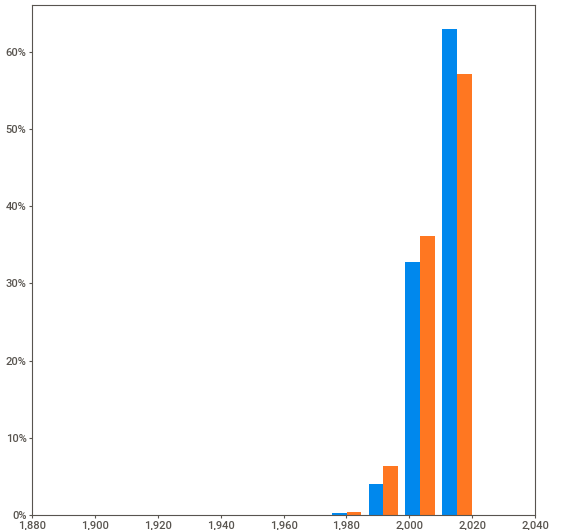
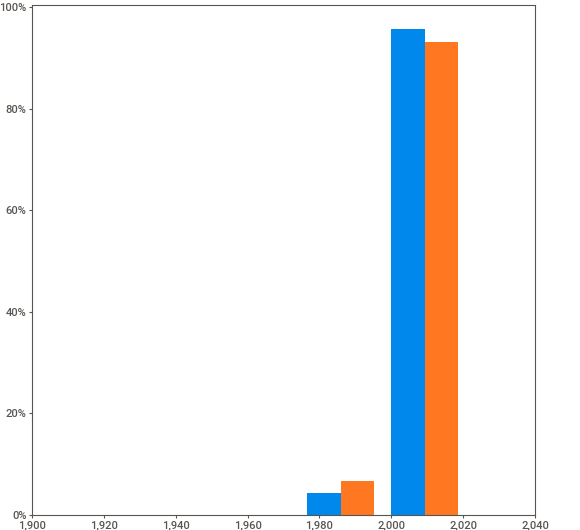
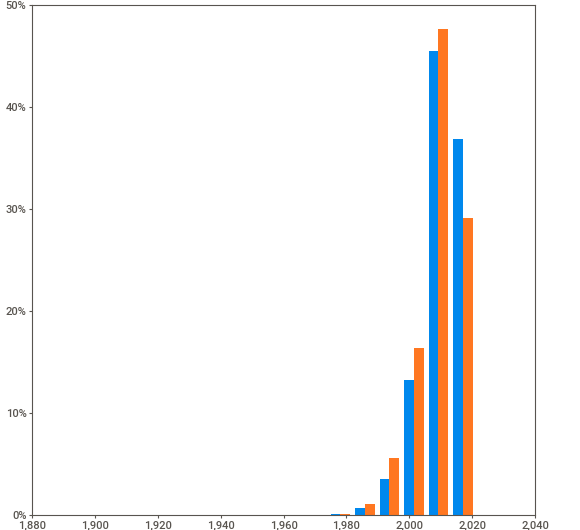
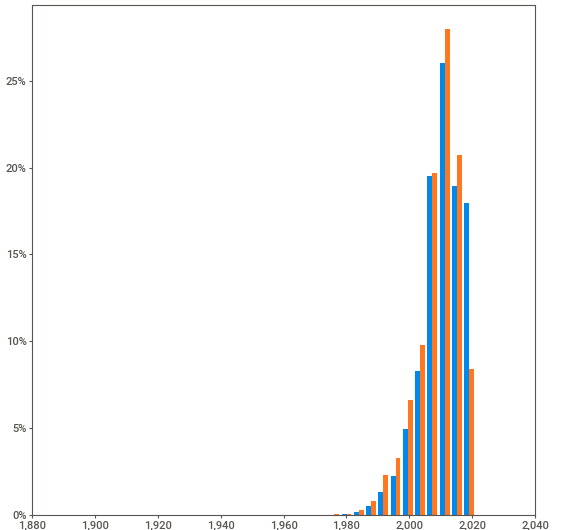
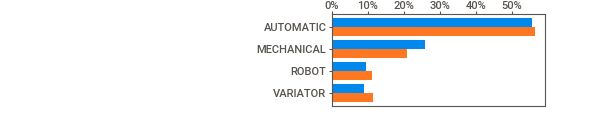
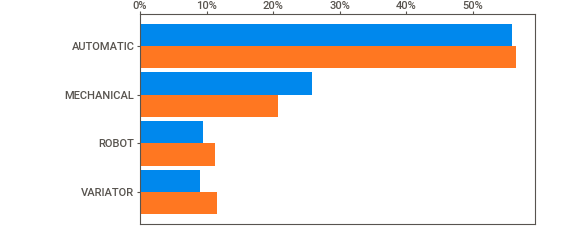
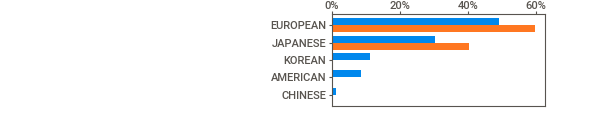
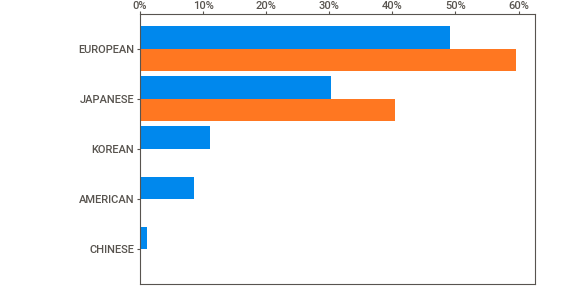
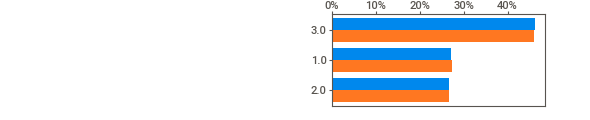
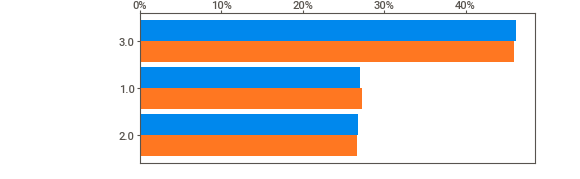
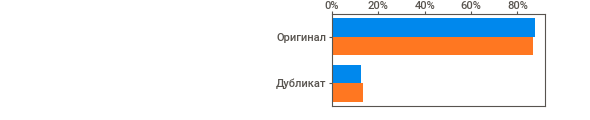
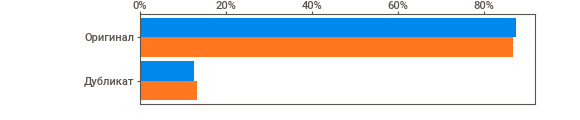
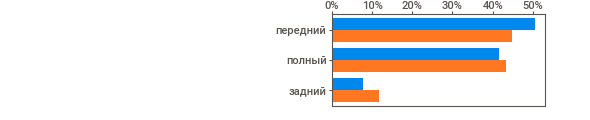
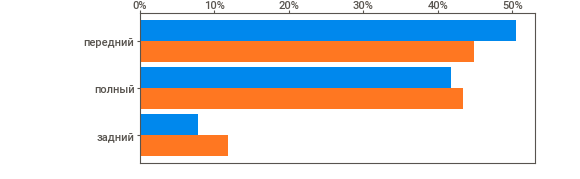
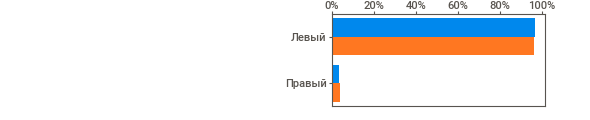
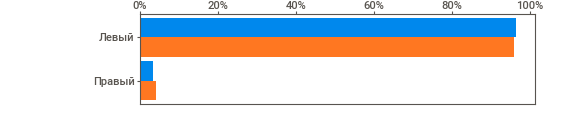
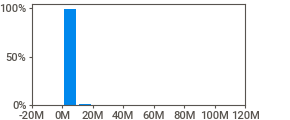
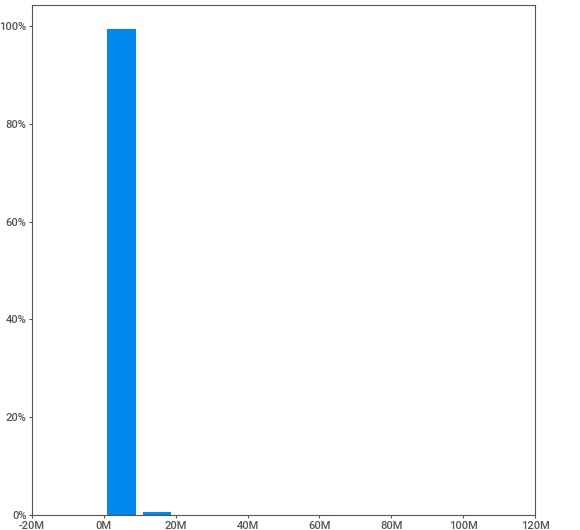
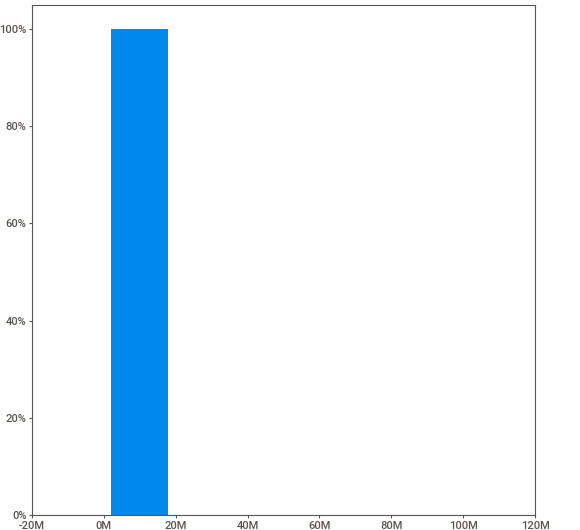
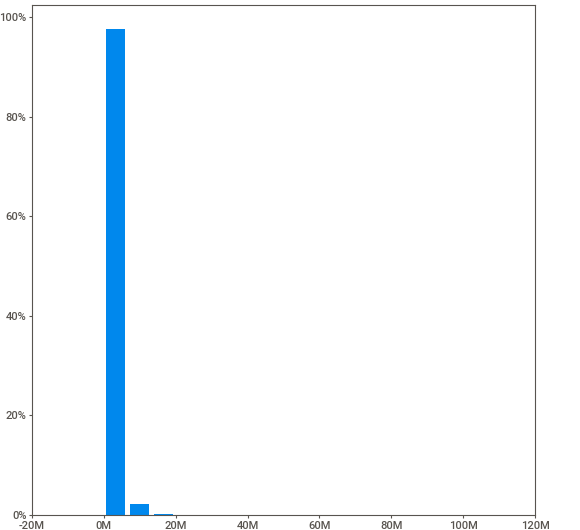
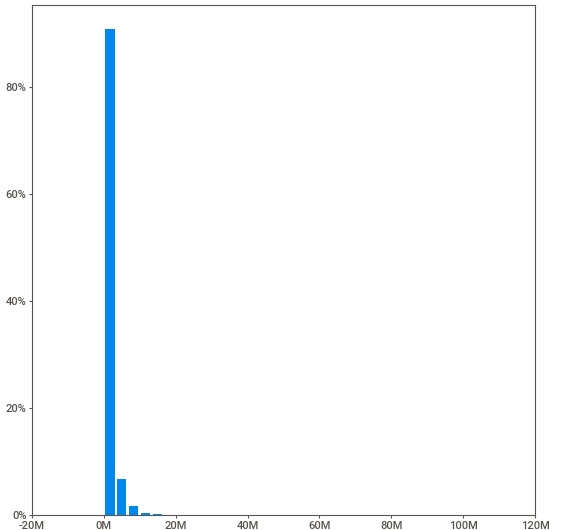
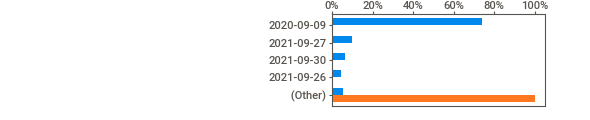
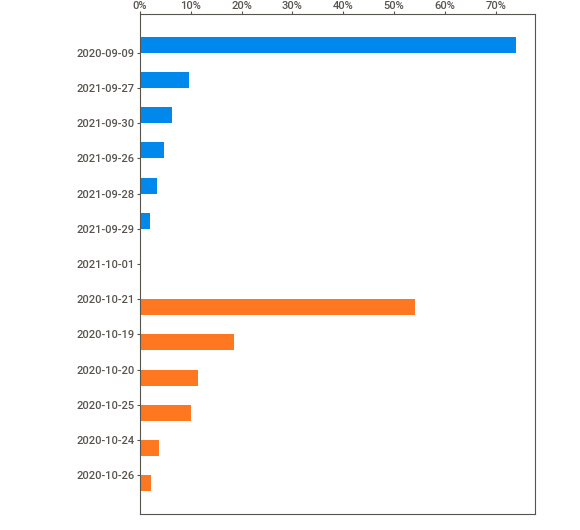
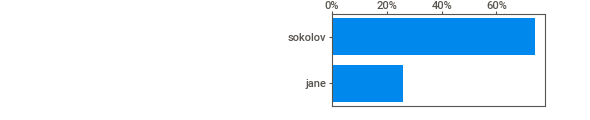
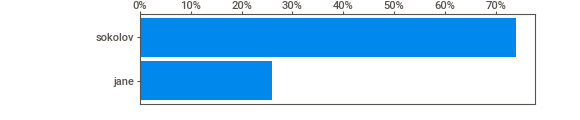
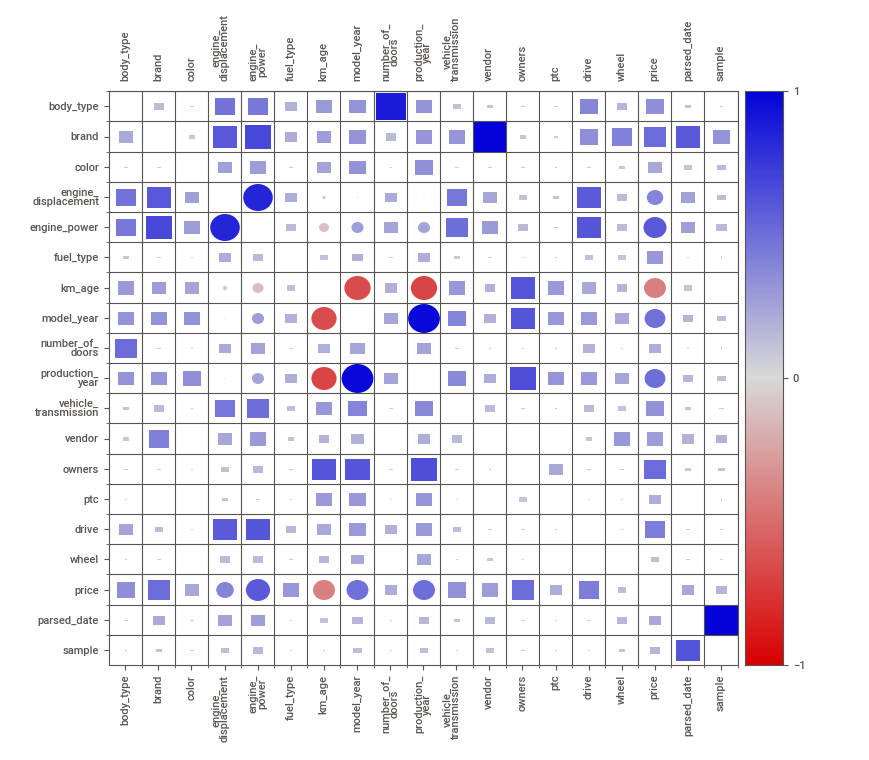
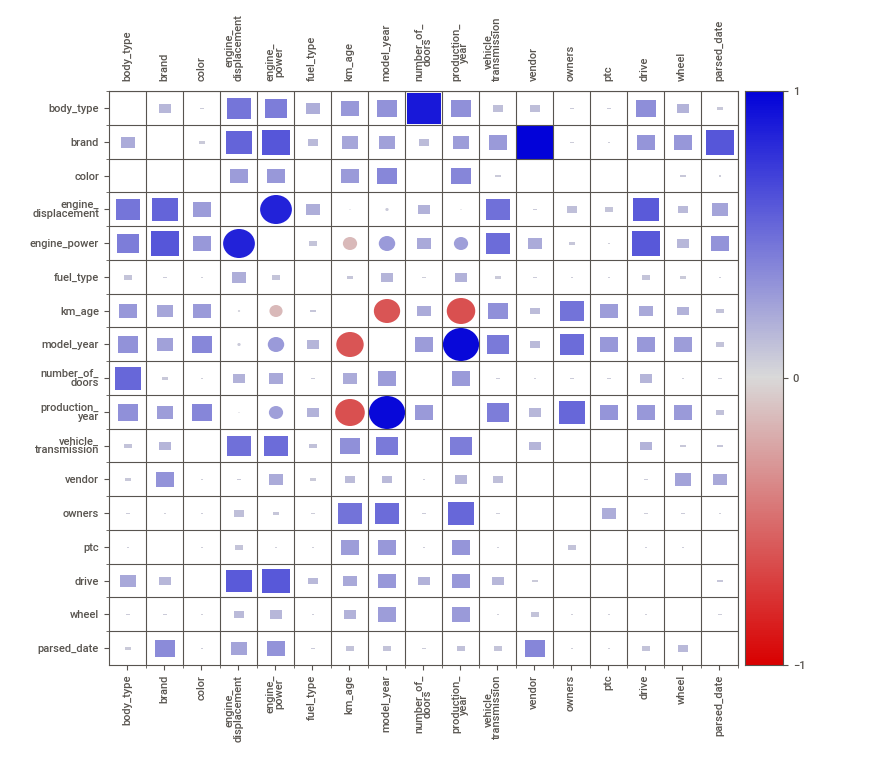

In [25]:
comp.show_notebook()

## Teatures TO DO

- **body_type** - fill na
- **brand** - 
- **color** - 
- **description** - 
- **engine_displacement** - 
- **engine_power** - 
- **fuel_type** - 
- **km_age** - 
- **model_year** - 
- **number_of_doors** - 
- **production_year** - 
- **vehicle_transmission** - 
- **vendor** - 
- **oweners** - 
- **owenership_duration** - 
- **ptc** - 
- **drive** - 
- **wheel** - 
- **price** - 

In [26]:
train.loc[train.body_type.isna()]

,body_type,brand,color,description,engine_displacement,engine_power,fuel_type,km_age,model_year,model_name,number_of_doors,production_year,vehicle_transmission,vendor,owners,ptc,drive,wheel,price,parsed_date,sample


In [27]:
train.body_type.value_counts(dropna=False)

внедорожник    44065
седан          39812
хэтчбек        12606
лифтбек         5358
универсал       4489
минивэн         2947
компактвэн      2552
купе            2064
пикап            794
кабриолет        242
родстер          191
фургон           174
микровэн          54
тарга              9
лимузин            7
фастбек            3
Name: body_type, dtype: int64

In [28]:
test.body_type.value_counts(dropna=False)

седан          13165
внедорожник    12346
хэтчбек         2609
лифтбек         2232
универсал       1276
минивэн          995
купе             982
компактвэн       489
пикап            290
родстер           99
фургон            97
кабриолет         90
микровэн           7
лимузин            6
тарга              2
фастбек            1
Name: body_type, dtype: int64

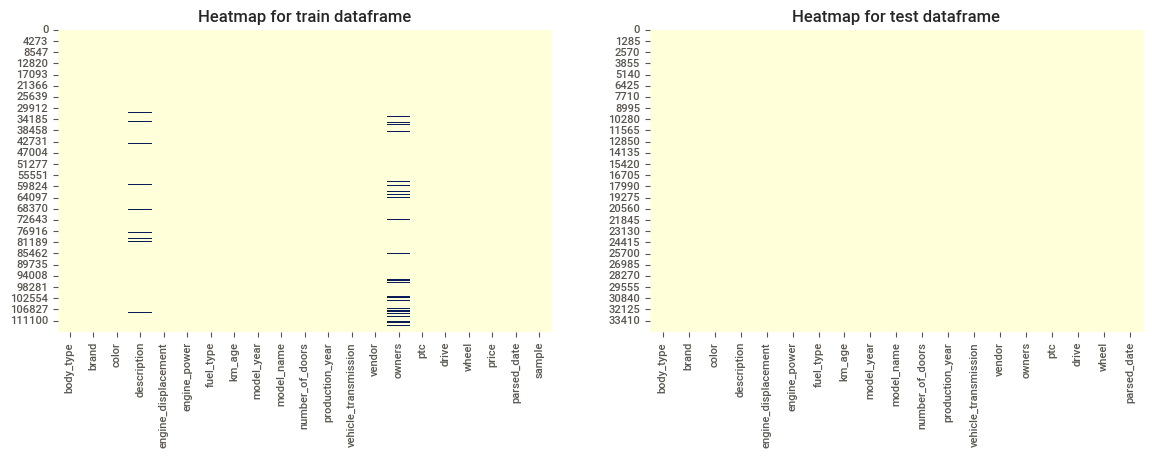

In [29]:
plot_nans_heatmap(train, test)

## notes, next steps

1. fill na
   - owners
2. feature engeneering
   - parced_year - production_year
3. price multiply * 0.86 for jane only
4. numerize cats
5. standartize nums

## preparing to simple model

In [30]:
train.dtypes

body_type                object
brand                    object
color                    object
description              object
engine_displacement     float64
engine_power            float32
fuel_type                object
km_age                  float32
model_year              float32
model_name               object
number_of_doors         float32
production_year         float32
vehicle_transmission     object
vendor                   object
owners                  float64
ptc                      object
drive                    object
wheel                    object
price                   float64
parsed_date              object
sample                   object
dtype: object

In [31]:
test.dtypes

body_type                object
brand                    object
color                    object
description              object
engine_displacement     float64
engine_power            float32
fuel_type                object
km_age                  float32
model_year              float32
model_name               object
number_of_doors         float32
production_year         float32
vehicle_transmission     object
vendor                   object
owners                  float32
ptc                      object
drive                    object
wheel                    object
parsed_date              object
dtype: object

## Modeling

In [32]:
if os.path.exists("models"):
    pass
else:
    os.mkdir("models")

### pre-modelling processing

In [33]:
data = preprocesing(train)
test_prep = preprocesing(test)

In [34]:
data.to_parquet("data/2022-04-08_train_pre-model.parquet")
test_prep.to_parquet("data/2022-04-08_test_pre-model.parquet")

In [35]:
data.dtypes

body_type                       object
brand                           object
color                           object
description                     object
engine_displacement            float64
engine_power                   float32
fuel_type                       object
km_age                         float32
model_year                     float32
model_name                      object
number_of_doors                  int64
production_year                  int64
vehicle_transmission            object
vendor                          object
owners                           int64
ptc                             object
drive                           object
wheel                           object
price                          float64
parsed_date             datetime64[ns]
sample                          object
diff_data                      float64
diff_data_years                float64
age_cat                         object
retro                            int64
most_wanted              

In [36]:
data.sample(5, random_state=42).T

,84022,64128,64226,43487,2657
body_type,внедорожник,седан,седан,хэтчбек,хэтчбек
brand,PORSCHE,KIA,KIA,CHEVROLET,SKODA
color,белый,белый,белый,синий,красный
description,рольф северо запад это первый мегамолл автомоб...,комплект зимних шин в подарок причина продажи ...,куплен новым у о д один хозяин обслуживался у ...,машина в полной боевой готовности масло меняло...,хорошее состояние газ бензин газ не оформлен п...
engine_displacement,3.0,1.4,1.4,1.6,1.2
engine_power,245.0,107.0,107.0,109.0,60.0
fuel_type,дизель,бензин,бензин,бензин,бензин
km_age,120676.0,53600.0,68793.0,181000.0,286000.0
model_year,2010.0,2015.0,2015.0,2004.0,2007.0
model_name,CAYENNE,RIO,RIO,LACETTI,FABIA


#### Taking a log2 of numeric variables

In [37]:
for col in ['engine_displacement', 'engine_power', 'km_age', 'model_year', 'production_year', 'diff_data', 'km_per_year', 'desc_count']:
    data[col] = np.log2(data[col] + 1)

#### Dropping cols and splitting to X and y

In [39]:
X = data.drop(['sample', 'price', 'parsed_date', 'description', 'ptc', 'diff_data_years'], axis=1)
y = data['price']

#### Train / Test split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [41]:
X_train.sample(5, random_state=42)

,body_type,brand,color,engine_displacement,engine_power,fuel_type,km_age,model_year,model_name,number_of_doors,production_year,vehicle_transmission,vendor,owners,drive,wheel,diff_data,age_cat,retro,most_wanted,good_cond,km_per_year,desc_count,dealer
102556,внедорожник,VOLKSWAGEN,белый,2.000000,7.942514,дизель,15.693732,10.976564,TOUAREG,5,10.977280,AUTOMATIC,EUROPEAN,2,полный,Левый,11.021674,not_bad,0,0,0,13.184632,6.149747,0
55251,внедорожник,HYUNDAI,зелёный,1.807355,6.584962,дизель,18.031879,10.964341,GALLOPER,5,10.965063,MECHANICAL,KOREAN,3,полный,Левый,13.016808,old,0,0,0,13.527114,5.209453,0
10543,седан,VOLVO,чёрный,1.765535,7.651052,бензин,17.609648,10.965063,S80,4,10.967947,AUTOMATIC,EUROPEAN,3,передний,Левый,12.815784,med,0,0,0,13.305952,6.044394,0
106334,внедорожник,LAND_ROVER,чёрный,2.584963,8.997179,бензин,17.941696,10.972980,RANGE_ROVER,5,10.972980,AUTOMATIC,EUROPEAN,3,полный,Левый,12.060020,med,0,0,0,14.393827,7.392317,0
104739,внедорожник,VOLVO,коричневый,1.807355,7.721099,бензин,17.307787,10.970825,XC90,5,10.975848,AUTOMATIC,EUROPEAN,2,полный,Левый,11.455841,not_bad,0,0,0,14.364273,7.451211,1


### CatBoostRegressor

In [42]:
if os.path.exists("models/2022-04-08_CatBoostRegressor.joblib"):
    with open("models/2022-04-08_CatBoostRegressor.joblib", "rb") as f:
        model_cb = joblib.load(f)
else:
    model_cb = CatBoostRegressor(
        iterations=1000,
        random_seed=42,
        eval_metric="MAPE",
        custom_metric=["R2", "MAE"],
        one_hot_max_size=50,
        depth=10,
        l2_leaf_reg=3,
        learning_rate=0.15,
        cat_features=[0, 1, 2, 5, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20],
    )
    model_cb.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        verbose_eval=0,
        use_best_model=True,
        plot=True,
    )
    with open("models/2022-04-08_CatBoostRegressor.joblib", "wb") as f:
        joblib.dump(model_cb, f, compress=9)

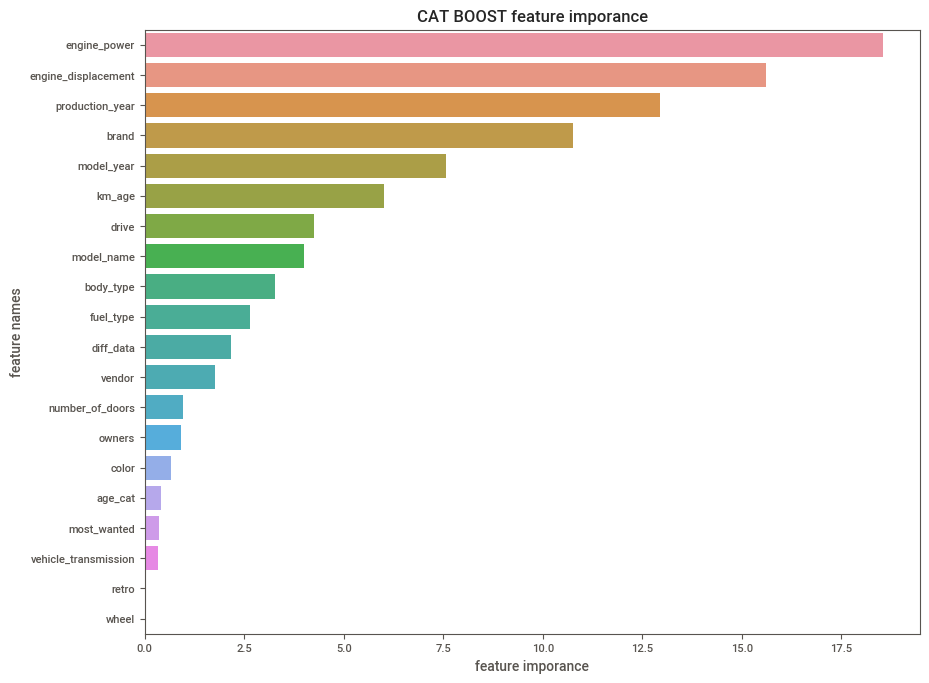

In [43]:
plot_feature_importance(model_cb.get_feature_importance(), X_train.columns, 'CAT BOOST')

In [44]:
y_pred_cb = model_cb.predict(X_test)

In [45]:
mape(y_test, y_pred_cb)*100

13.755837716719052

### XGBRegressor

In [46]:
XG_data = data.copy()

#### Encoding categoricals, dropping cols, train-test split

In [47]:
for col in XG_data.select_dtypes('object').columns:
    XG_data[col] = XG_data[col].astype('category').cat.codes

In [48]:
X_num = XG_data.drop(['sample', 'price', 'parsed_date', 'description', 'diff_data_years'], axis=1) # pts?
y_num = XG_data['price']

In [49]:
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(
    X_num, y_num, test_size=0.20, random_state=42, shuffle=True
)

#### training and calculating metric and importancies

In [50]:
model_xbr = train_or_load(
    xgb.XGBRegressor(
        max_depth=20, min_child_weight=1, n_estimators=500, n_jobs=-1, eta=0.11
    ),
    X_train_num,
    y_train_num,
    "models/2022-04-08_XGBRegressor.joblib",
)

In [51]:
y_pred_xbr = model_xbr.predict(X_test_num)

In [52]:
mape(y_test, y_pred_xbr)*100

14.098383295717085

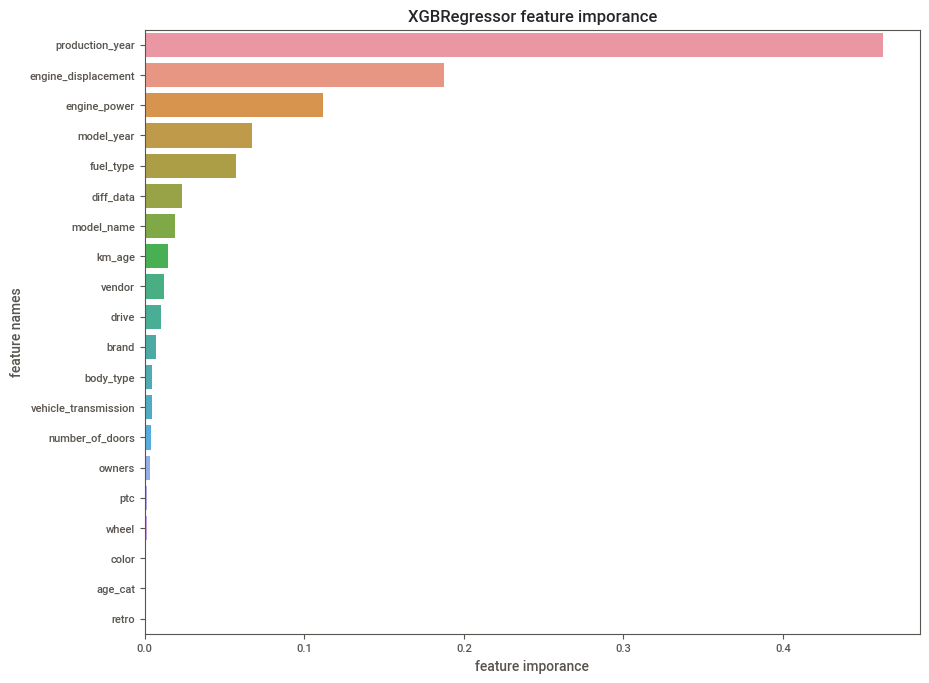

In [53]:
plot_feature_importance(model_xbr.feature_importances_, X_train_num.columns, 'XGBRegressor')

### RandomForestRegressor

In [54]:
model_rfr = train_or_load(
    RandomForestRegressor(random_state=42, n_jobs=-1, verbose=1),
    X_train_num,
    y_train_num,
    "models/2022-04-08_RandomForestRegressor.joblib",
)

In [55]:
y_pred_rfr = model_rfr.predict(X_test_num)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


In [56]:
mape(y_test, y_pred_rfr)*100

14.252626406849975

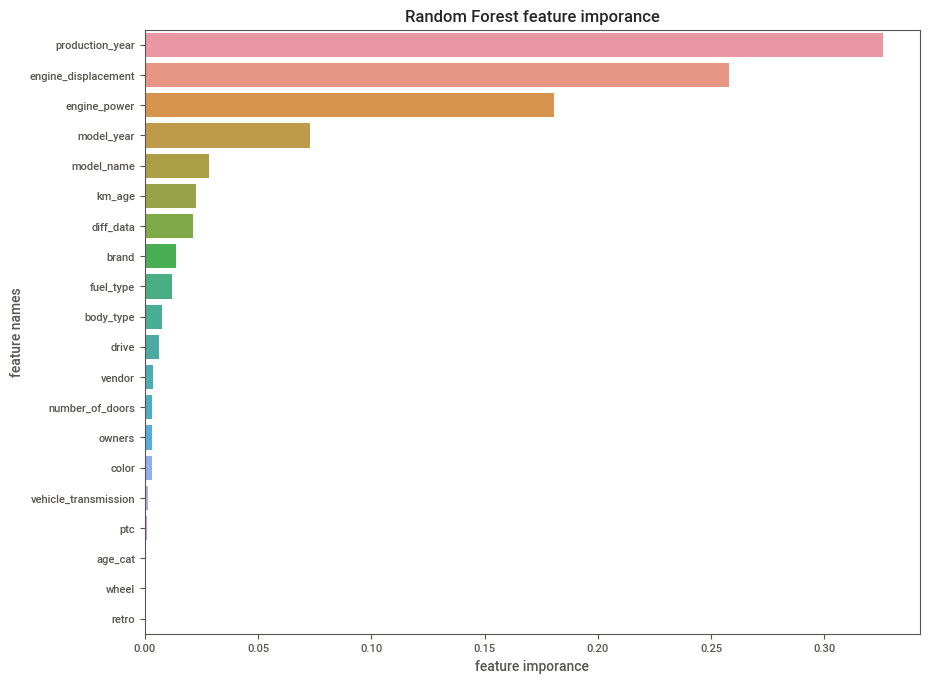

In [57]:
plot_feature_importance(model_rfr.feature_importances_, X_train_num.columns, 'Random Forest')

### AdaBoostRegressor (dummies)

In [58]:
X_train["train/test"] = "train"
X_test["train/test"] = "test"

ada_data = X_train.append(X_test)
ada_prep = ada_data.drop(columns=["train/test"]).pipe(get_dumb_dummies)

ada_train = ada_prep.loc[ada_data["train/test"] == "train"]
ada_test = ada_prep.loc[ada_data["train/test"] == "test"]

In [59]:
model_ada = train_or_load(
    AdaBoostRegressor(random_state=42),
    ada_train,
    y_train,
    "models/2022-04-08_AdaBoostRegressor_dummies.joblib",
)

In [60]:
y_pred_ada = model_ada.predict(ada_test)

In [61]:
mape(y_test, y_pred_ada)*100

405.1923288385895

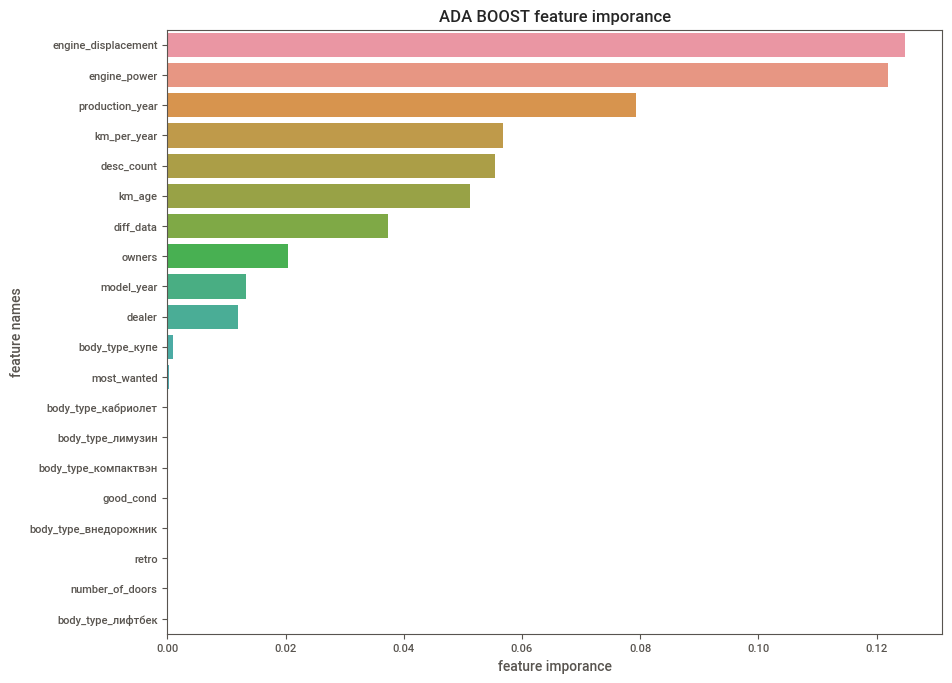

In [62]:
plot_feature_importance(model_ada.feature_importances_ , ada_train.columns, 'ADA BOOST')

### AdaBoostRegressor (ordinal)

In [63]:
model_ada = train_or_load(
    AdaBoostRegressor(random_state=42),
    X_train_num,
    y_train_num,
    "models/2022-04-08_AdaBoostRegressor_ordinal.joblib",
)

In [64]:
y_pred_ada = model_ada.predict(X_test_num)

In [65]:
mape(y_test_num, y_pred_ada)*100

562.5419084630358

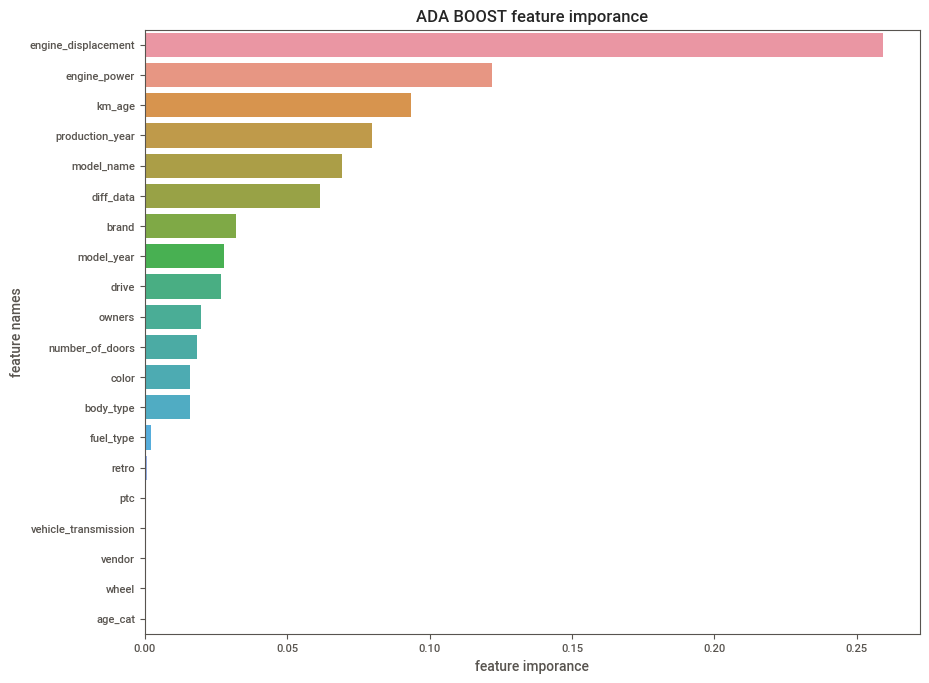

In [66]:
plot_feature_importance(model_ada.feature_importances_ , X_train_num.columns, 'ADA BOOST')

## Conclusion

1. please use new notebook for experiments, don't change this one. New files, preprocessed here, are:
  - [2022-04-08_train_pre-model.parquet](data/2022-04-08_train_pre-model.parquet)
  - [2022-04-08_test_pre-model.parquet](data/2022-04-08_test_pre-model.parquet)
2. consider keeping the most important fields, discovered by models:
  - **catboost** - engine_power, engine_displacement, production_year, brand, model_year, km_age, drive, model_name, body_type, fuel_type, diff_data, vendor
  - **xgboost** - production_year, engine_displacement, engine_power, model_year, fuel_type
  - **randomforest** - production_year, engine_displacement, engine_power, model_year, model_name, km_age
  - **adaboost** - engine_displacement, engine_power, production_year, km_per_year, desc_count, km_age, diff_data, owners, model_year, dealer
3. consider dropping adaboost or use it for stacking only
4. you can explicitly specify required fields reading parquet files
5. do a LOT of experiments:
  - try more algorythms
  - try to log or not to log **y**
  - try to standartize or not to standartize
  - try to deal with description
  - try automl
  - try ordinal vs dummy categorical encoding for different algorythms
  - try randomly drop features
6. LOG EVERYTHING - use [readme file](README.md) to log experiment results


---

[next file - experiments sklearn](2022-04-12_experiments-sklearn.ipynb)
[next file - pycaret model selection](2022-04-11_experiments_pycaret_preprocessing_and_model_selection.ipynb)